### Business Problem Overview

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
**For many incumbent operators, retaining high profitable customers is the number one business goal.**

**To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.**

### Objective

In this project, we will 
- analyze customer-level data of a leading telecom firm, 
- build predictive models to identify customers at high risk of churn and 
- identify the main indicators of churn.

#### Churn Definition

This project is based on Indian and Southeast Asian market and fillowing **Usage-based Churn definition** will be used:

*Usage-based churn:Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.*

#### High Value Churn

In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

#### Data and Business Objective

**dataset**: The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively.

**business objective**: is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. 

####  Understanding Customer Behaviour during Churn

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

1. The **‘good’ phase**: In this phase, the customer is happy with the service and behaves as usual.

2. The **‘action’ phase**: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. The **‘churn’ phase**: In this phase, the customer is said to have churned. We define churn based on this phase.

In this project, since we are working over a four-month window:
* the first two months (6th and 7th month data) are the ‘good’ phase, 
* the third month (8th month) is the ‘action’ phase, 
* while the fourth month (9th month) is the ‘churn’ phase.

### Import all the required Libraries

In [3]:
# filter warnings
import os
import warnings
warnings.filterwarnings('ignore')

In [4]:
# import numpy and pandas
import pandas as pd
import numpy as np

In [5]:
# import libraries to plot
import matplotlib.pyplot as plt
import seaborn as sns
# do an inline so that plt.show() is not required everytime
%matplotlib inline

In [6]:
# Import sklearn libraries
from scipy.stats import norm
from scipy import stats

import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Improting the PCA module
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA


from sklearn import metrics
# Importing classification report and confusion matrix etc from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, recall_score



from sklearn.linear_model import LogisticRegression

# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# import graphviz
from IPython.display import Image
#import pydotplus
#import pydot as pydot_ng
from sklearn import tree
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz


import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.svm import SVC

In [ ]:
# import for pre-processing
# scale (this is same as standard scalar)
from sklearn.preprocessing import scale
# label encoding
from sklearn.preprocessing import LabelEncoder

# import for model selection:
# splitting data into training and test data (validation set)
from sklearn.model_selection import train_test_split
# import for creating K-folds
from sklearn.model_selection import KFold
# import for CV using folds created
from sklearn.model_selection import cross_val_score
# import for grid search cv for Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

# for deleting unused variables
import gc

### Generic Function (Used multiple times)

In [2]:
def get_nulls_report(df,apply_style="Y"):
    if apply_style=="Y":
        cm = sns.light_palette("orange", as_cmap=True)
        return pd.DataFrame([df.isnull().sum(),round(100*(df.isnull().sum()/len(df.index)), 2)]).T.rename(columns={0:'Total Nulls',1:'Nulls Percentage'}).\
sort_values(by='Nulls Percentage',ascending=False).style.background_gradient(cmap=cm)
    else:
        return pd.DataFrame([df.isnull().sum(),round(100*(df.isnull().sum()/len(df.index)), 2)]).T.rename(columns={0:'Total Nulls',1:'Nulls Percentage'}).\
sort_values(by='Nulls Percentage',ascending=False)

In [3]:
def printMetrics(y_test,y_pred):
    cp = confusion_matrix(y_test,y_pred)
    sensitivity = cp[1,1]/(cp[1,0]+cp[1,1])
    specificity =  cp[0,0]/(cp[0,1]+cp[0,0])
    precision = cp[1,1]/(cp[0,1]+cp[1,1])
    print('Confusion Matrix: \n',cp)
    print("Sensitivity: ", sensitivity)
    print("Specificity: ",specificity)
    print("AUC Score: ", roc_auc_score(y_test,y_pred)) 
    print("Accuracy: ",accuracy_score(y_test,y_pred))
    print(classification_report(y_test, y_pred))

In [4]:
def plotLiftChart(actual, predicted,title_str):
    df_dict = {'actual': list (actual), 'pred': list(predicted)}
    df = pd.DataFrame(df_dict)
    pred_ranks = pd.qcut(df['pred'].rank(method='first'), 100, labels=False)
    actual_ranks = pd.qcut(df['actual'].rank(method='first'), 100, labels=False)
    pred_percentiles = df.groupby(pred_ranks).mean()
    actual_percentiles = df.groupby(actual_ranks).mean()
    plt.title(title_str)
    plt.plot(np.arange(.01, 1.01, .01), np.array(pred_percentiles['pred']),
             color='darkorange', lw=2, label='Prediction')
    plt.plot(np.arange(.01, 1.01, .01), np.array(pred_percentiles['actual']),
             color='navy', lw=2, linestyle='--', label='Actual')
    plt.ylabel('Target Percentile')
    plt.xlabel('Population Percentile')
    plt.xlim([0.0, 1.0])
    plt.ylim([-0.05, 1.05])
    from pylab import rcParams
    rcParams['figure.figsize'] = 10, 4

    plt.legend(loc="best")
    plt.show()

In [5]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(9,6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

### Load Data and Data Cleaning

In [6]:
# Fetch the Telecom Churn Data
telecom_data = pd.read_csv('./telecom_churn_data.csv')

In [7]:
# Inspect the data from the dataframe
telecom_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [8]:
# Checking the Shape of the Dataframe
telecom_data.shape

(99999, 226)

**INFO** - The Dataframe Contains below details
      - No Of Records - 99999
      - No Of Columne - 226 (This is a big number , we definetly needs feature reduction)

In [9]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [10]:
# Fetching the Null Reports of the Dataset
get_nulls_report(telecom_data)

,Total Nulls,Nulls Percentage
arpu_3g_6,74846,74.85
night_pck_user_6,74846,74.85
total_rech_data_6,74846,74.85
arpu_2g_6,74846,74.85
max_rech_data_6,74846,74.85
fb_user_6,74846,74.85
av_rech_amt_data_6,74846,74.85
date_of_last_rech_data_6,74846,74.85
count_rech_2g_6,74846,74.85
count_rech_3g_6,74846,74.85


**INFO** - It looks like lots of the data contains Nulls Value
     - We need to clean or Impute such records/Columns

##### For many incumbent operators, retaining high profitable customers is the number one business goal.We will do the same in our Analysis.

#### Data Analysis on the Recharge the customer made

In [11]:
recharge_amnt_columns = [col for col in telecom_data.columns if 'rech_amt' in col or  'rech_data' in col]

In [12]:
recharge_amnt_columns

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'total_rech_amt_9',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'max_rech_amt_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'total_rech_data_9',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'max_rech_data_9',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'av_rech_amt_data_9']

INFO - We have 3 categories of columns which will be used to indetify the top customers

- **CATEGORY 1** -> total recharge amount,
- **CATEGORY 2** -> maximum recharge amount and 
- **CATEGORY 3** -> average recharge amount for data.
- **CATEGORY 4** -> total recharge for data
- **CATEGORY 5** -> maximum recharge for data

In [ ]:
# let us check if there are any missing values for recharge amount
get_nulls_report(telecom_data[recharge_amnt_columns])

INFO - 
  - Obsrervation is **74-75%** of data is missing or null in all the 5 category mentioned above

In [14]:
recharge_amnt_columns_6 = telecom_data.columns[telecom_data.columns.str.contains('rech_amt_6|rech_data_6|rech_amt_data_6')]

telecom_data.loc[:,recharge_amnt_columns_6].describe()

,total_rech_amt_6,max_rech_amt_6,total_rech_data_6,max_rech_data_6,av_rech_amt_data_6
count,99999.000000,99999.000000,25153.000000,25153.000000,25153.000000
mean,327.514615,104.637486,2.463802,126.393392,192.600982
std,398.019701,120.614894,2.789128,108.477235,192.646318
min,0.000000,0.000000,1.000000,1.000000,1.000000
25%,109.000000,30.000000,1.000000,25.000000,82.000000
50%,230.000000,110.000000,1.000000,145.000000,154.000000
75%,437.500000,120.000000,3.000000,177.000000,252.000000
max,35190.000000,4010.000000,61.000000,1555.000000,7546.000000


We can see that total_rech_data has discrete values and the non NA values for total_rech_data and av_rech_amt_data is the same, thus we can find out the total recharge amount for data from the two.

In [15]:
# Checking the total_rech_data is NA/null and value is present for av_rech_amt_data and vice versa
# check how many av_rech_amt_data_6 is NA
null_data_6 = telecom_data['total_rech_data_6'].isnull()
null_data_7 = telecom_data['total_rech_data_7'].isnull()
null_data_8 = telecom_data['total_rech_data_8'].isnull()

# check if any value is present for these rows for total_rech_data_x
print("Total Recharge Data 6 Nulls are -",telecom_data.loc[null_data_6,'total_rech_data_6'].sum())
print("Total Recharge Data 7 Nulls are -",telecom_data.loc[null_data_7,'total_rech_data_7'].sum())
print("Total Recharge Data 8 Nulls are -",telecom_data.loc[null_data_8,'total_rech_data_8'].sum())

# check if any value is present for these rows for av_rech_amt_data_x
print("Avg Recharge amt 6 Nulls are -",telecom_data.loc[null_data_6,'av_rech_amt_data_6'].sum())
print("Avg Recharge amt 7 Nulls are -",telecom_data.loc[null_data_7,'av_rech_amt_data_7'].sum())
print("Avg Recharge amt 8 Nulls are -",telecom_data.loc[null_data_8,'av_rech_amt_data_8'].sum())

Total Recharge Data 6 Nulls are - 0.0
Total Recharge Data 7 Nulls are - 0.0
Total Recharge Data 8 Nulls are - 0.0
Avg Recharge amt 6 Nulls are - 0.0
Avg Recharge amt 7 Nulls are - 0.0
Avg Recharge amt 8 Nulls are - 0.0


INFO - The observation is ,if the total_rech_data is null , then the avg_rech_amt is also null
     - The above is true for Vice Versa
     - We are good to impute 0 for all the above records , as this means no recharge

In [16]:
telecom_data[['total_rech_data_6','total_rech_data_7','total_rech_data_8']]=telecom_data[['total_rech_data_6','total_rech_data_7','total_rech_data_8']].fillna(0)
telecom_data[['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8']]=telecom_data[['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8']].fillna(0)

In [17]:
# New derived variable total recharge amount for data: av_rech_amt_data_x*total_rech_data_x
telecom_data['total_rech_amt_data_6'] = telecom_data.av_rech_amt_data_6*telecom_data.total_rech_data_6
telecom_data['total_rech_amt_data_7'] = telecom_data.av_rech_amt_data_7*telecom_data.total_rech_data_7
telecom_data['total_rech_amt_data_8'] = telecom_data.av_rech_amt_data_8*telecom_data.total_rech_data_8

##### New Derived Variable 
- total_avg_rech_amnt_good_ph : We will define total average recharge amount for good phase as the average of total recharge amount and total recharge amount for data for months 6 and 7 (good phase months).

In [18]:
telecom_data['total_avg_rech_amnt_good_ph'] = (telecom_data.total_rech_amt_6 +telecom_data.total_rech_amt_data_6 \
                                               + telecom_data.total_rech_amt_7+telecom_data.total_rech_amt_data_7)/4

#### Criteria to Filter High Value Customers####
- Those people who have total average recharge amount for good phase greater than the 70th percentile value.

In [19]:
high_value_filter = telecom_data.total_avg_rech_amnt_good_ph >= telecom_data.total_avg_rech_amnt_good_ph.quantile(0.7)

In [20]:
# Update the Dataframe with only High Value Customers
telecom_data = telecom_data.loc[high_value_filter,:]

In [21]:
# Total High Value Customers after filtering the data are
len(telecom_data.index)

30001

#### creating labels for churned customers.

In [22]:
# Now let us label the churned customers
# define a new column in data frame as 'churn' with value as 1 if customer has churned and 0 if customer has not churned
# Initially set all the values as 0
telecom_data['churn']= 0

In [23]:
# the following columns will be used to find the churned customers in the 9th month 
# total_ic_mou_9, total_ic_mou_9, vol_2g_mb_9 and vol_3g_mb_9
# let's check if any NA/Null values are present
ls_9 = ['total_ic_mou_9', 'total_ic_mou_9', 'vol_2g_mb_9','vol_3g_mb_9']
100*telecom_data.loc[:,ls_9].isnull().sum()/len(telecom_data)

total_ic_mou_9    0.0
total_ic_mou_9    0.0
vol_2g_mb_9       0.0
vol_3g_mb_9       0.0
dtype: float64

In [24]:
# define is_churned boolean flag for customers where above values are zero
is_churned = (telecom_data.total_ic_mou_9 == 0) & (telecom_data.total_ic_mou_9 == 0) & (telecom_data.vol_2g_mb_9 ==0)& \
(telecom_data.vol_3g_mb_9 ==0)

In [25]:
# set all such rows fulfilling is_churned condition as 1
telecom_data.loc[is_churned,'churn']=1

In [26]:
# let us check what's the % of churned customers
100*telecom_data.churn.sum()/len(is_churned)

8.406386453784874

INFO 
 - We see that approx. 8.4% of high value customers have churned

In [27]:
# let's extract all list of 9th Month (churned month) Columns
month_9_columns =  telecom_data.columns[telecom_data.columns.str.contains('_9')]

In [28]:
# drop all columns corresponding to the attributes of churn phase
telecom_data.drop(month_9_columns,axis=1,inplace=True)

In [29]:
# let's check how many columns remain
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Columns: 177 entries, mobile_number to churn
dtypes: float64(140), int64(28), object(9)
memory usage: 40.7+ MB


In [30]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Columns: 177 entries, mobile_number to churn
dtypes: float64(140), int64(28), object(9)
memory usage: 40.7+ MB


In [31]:
100*telecom_data.isnull().sum()/len(telecom_data.index)

mobile_number                   0.000000
circle_id                       0.000000
loc_og_t2o_mou                  0.746642
std_og_t2o_mou                  0.746642
loc_ic_t2o_mou                  0.746642
last_date_of_month_6            0.000000
last_date_of_month_7            0.089997
last_date_of_month_8            0.549982
arpu_6                          0.000000
arpu_7                          0.000000
arpu_8                          0.000000
onnet_mou_6                     1.816606
onnet_mou_7                     1.789940
onnet_mou_8                     3.913203
offnet_mou_6                    1.816606
offnet_mou_7                    1.789940
offnet_mou_8                    3.913203
roam_ic_mou_6                   1.816606
roam_ic_mou_7                   1.789940
roam_ic_mou_8                   3.913203
roam_og_mou_6                   1.816606
roam_og_mou_7                   1.789940
roam_og_mou_8                   3.913203
loc_og_t2t_mou_6                1.816606
loc_og_t2t_mou_7

Let's create a function to **analyze_feature** across months 6,7 (good phase) and 8.This function will do the following:
* create box plots to compare variable distribution across months 6,7 and 8 for churn and non-churn customers.
* create summary of the mean and standard deviation of variable distribution across months 6,7 and 8 for churn and non-churn customers.

In [32]:
# create function to anlyze the features across 6th, 7th and 8th month
def analyze_feature(feature_start):
    sns.set_style("whitegrid")
    plt.rcParams["figure.figsize"] = [17, 7]
    fig = plt.figure()
    print("Churn Stats (mean and standard deviation):")
    cols = {c: feature_start + "_" + str(c) for c in [6,7,8]}
    print(cols)
    frame_data = []
    [frame_data.append({
        "mean_6": telecom_data[telecom_data["churn"] == churn][cols[6]].mean(),
        "mean_7": telecom_data[telecom_data["churn"] == churn][cols[7]].mean(),
        "mean_8": telecom_data[telecom_data["churn"] == churn][cols[8]].mean(),
        "std_6": telecom_data[telecom_data["churn"] == churn][cols[6]].std(),
        "std_7": telecom_data[telecom_data["churn"] == churn][cols[7]].std(),
        "std_8": telecom_data[telecom_data["churn"] == churn][cols[8]].std()
    }) for churn in [0,1]]
    
    f,axes = plt.subplots(nrows=1, ncols=3)
    sns.boxplot(data=telecom_data, y=feature_start + "_6", x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[0], palette="BrBG", color="skyblue")
    sns.boxplot(data=telecom_data, y=feature_start + "_7",  x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[1], palette="BrBG", color="skyblue")
    sns.boxplot(data=telecom_data, y=feature_start + "_8",  x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[2], palette="BrBG", color="skyblue")
    return pd.DataFrame(frame_data,index={"Non Churned","Churned"}).round(2)

#### recharge amount related variables

In [33]:
#let's again extract the recharge amount related columns
recharge_amnt_columns =  telecom_data.columns[telecom_data.columns.str.contains('rech_amt')]

recharge_amnt_columns

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'total_rech_amt_data_6', 'total_rech_amt_data_7',
       'total_rech_amt_data_8'],
      dtype='object')

Churn Stats (mean and standard deviation):
{6: 'total_rech_amt_6', 7: 'total_rech_amt_7', 8: 'total_rech_amt_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Non Churned,649.56,663.82,614.54,548.02,574.33,615.19
Churned,782.50,624.30,255.57,675.28,663.40,450.55


<Figure size 1224x504 with 0 Axes>

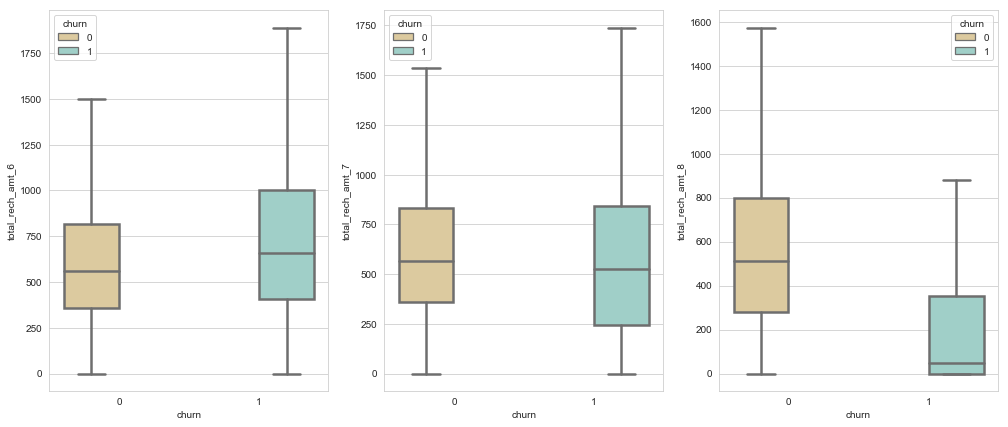

In [34]:
# let's analyze total recharge amount:
analyze_feature('total_rech_amt')

We do see a drop in the total recharge amount for churned customers.

Churn Stats (mean and standard deviation):
{6: 'total_rech_amt_data_6', 7: 'total_rech_amt_data_7', 8: 'total_rech_amt_data_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Non Churned,460.70,545.73,498.19,1447.90,1500.10,1685.29
Churned,402.12,337.63,82.54,1047.33,1165.83,470.96


<Figure size 1224x504 with 0 Axes>

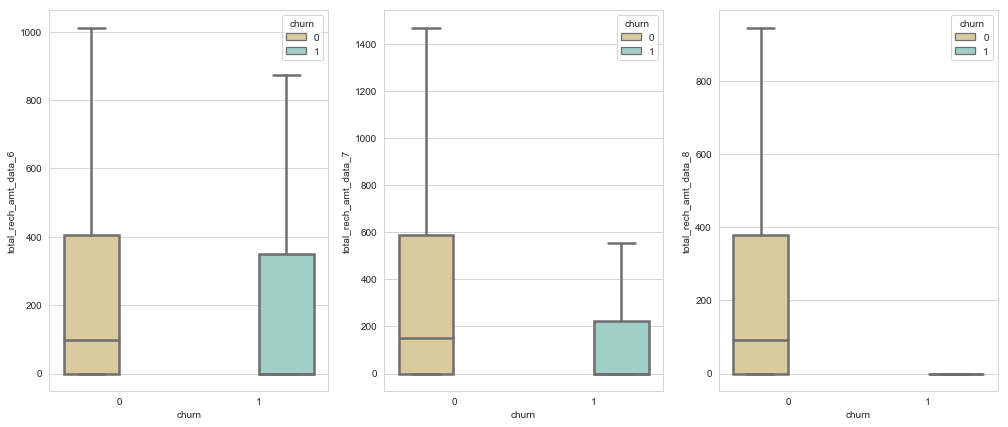

In [35]:
# let's analyze total recharge amount for data:
analyze_feature('total_rech_amt_data')

INFO 
 - We see that there is a significant drop in total recharge amount for data in 8th month (action phase) for churned customers.

Churn Stats (mean and standard deviation):
{6: 'max_rech_amt_6', 7: 'max_rech_amt_7', 8: 'max_rech_amt_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Non Churned,168.85,173.23,166.78,171.50,176.37,170.97
Churned,173.98,161.00,87.89,212.49,228.85,180.84


<Figure size 1224x504 with 0 Axes>

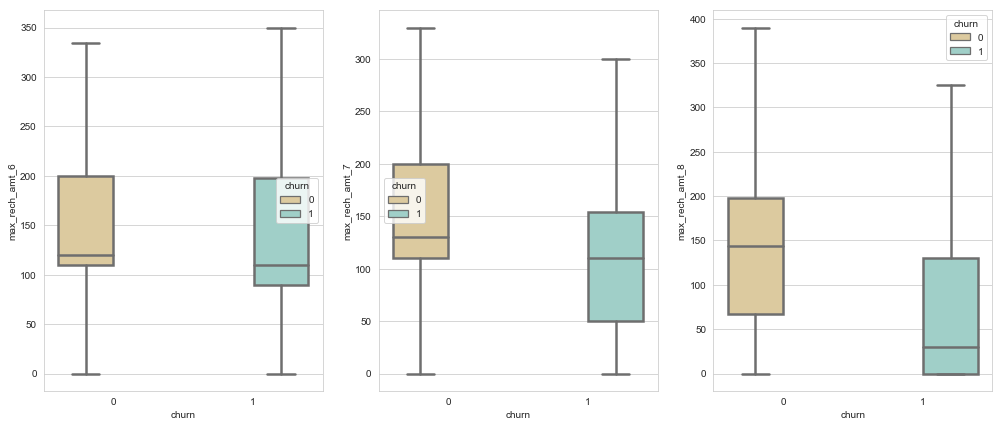

In [36]:
# let's analyze maximum recharge amount for data:
analyze_feature('max_rech_amt')

INFO 
 - We observe drop in maximum recharge amount as well.

- As we have already derived total recharge amount for data using average recharge amount for data and total recharge for data let's drop these columns.

In [37]:
# drop av_rech_amt_data and total_rech_data columns as total_rech_amt_data derived using these columns.
telecom_data.drop(['av_rech_amt_data_6','av_rech_amt_data_7'
                   ,'av_rech_amt_data_8','total_rech_data_6','total_rech_data_7','total_rech_data_8'],axis=1,inplace=True)

In [38]:
# Let us define 3 new derived columns
# total recharge amount for good phase: total_rech_amt_good_ph
# total recharge amount data for good phase: total_rech_amt_data_good_ph
# max recharge amount for good phase: max_rech_amt_good_ph

telecom_data['total_rech_amt_good_ph'] = (telecom_data.total_rech_amt_6 + telecom_data.total_rech_amt_7)/2
telecom_data['total_rech_amt_data_good_ph'] = (telecom_data.total_rech_amt_data_6 + telecom_data.total_rech_amt_data_7)/2
telecom_data['max_rech_amt_good_ph'] = (telecom_data.max_rech_amt_6 + telecom_data.max_rech_amt_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['total_rech_amt_6','total_rech_amt_7'
              ,'max_rech_amt_6','max_rech_amt_7','total_rech_amt_data_6','total_rech_amt_data_7'],axis=1,inplace=True)

# also drop total_avg_rech_amnt_good_ph as we are using the component columns defined above
telecom_data.drop('total_avg_rech_amnt_good_ph',axis=1,inplace=True)

#### last day recharge amount

In [39]:
#let's extract the last day recharge amount columns
last_day_rech_amt = telecom_data.columns[telecom_data.columns.str.contains('day')]

Churn Stats (mean and standard deviation):
{6: 'last_day_rch_amt_6', 7: 'last_day_rch_amt_7', 8: 'last_day_rch_amt_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Non Churned,100.36,102.08,97.35,140.19,138.95,145.09
Churned,106.67,81.52,38.43,177.76,159.67,134.92


<Figure size 1224x504 with 0 Axes>

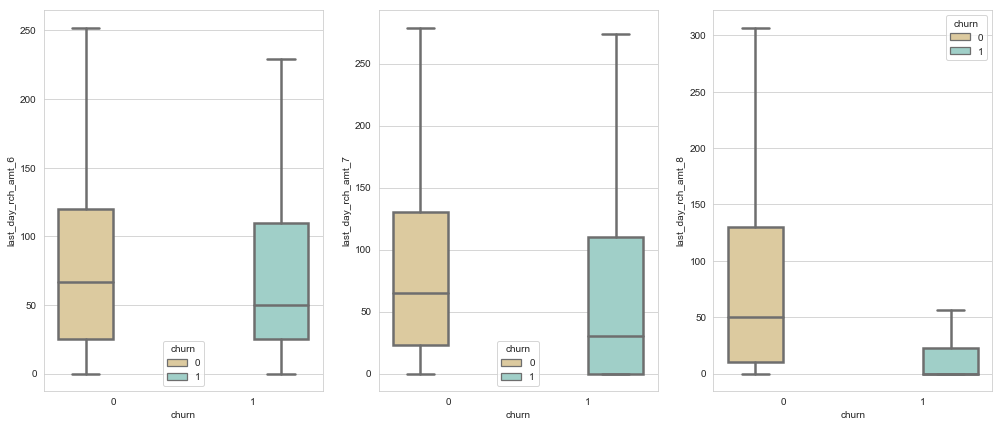

In [40]:
# let's check the mean variation in last day recharge for churned and non churned customers
analyze_feature('last_day_rch_amt')

INFO - We can see that there is a significant drop in last month recharge amount for churned customers.

In [41]:
# Let us define new derived column
# last day recharge amount for good phase: last_day_rch_amt_good_ph
telecom_data['last_day_rch_amt_good_ph'] = (telecom_data.last_day_rch_amt_6 + telecom_data.last_day_rch_amt_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['last_day_rch_amt_6','last_day_rch_amt_7'],axis=1,inplace=True)

**Other recharge related variables**

In [42]:
# Let's check other recharge related variables:
ls_recharge = telecom_data.columns[telecom_data.columns.str.contains('rech_num|max_rech_data',regex=True)]

In [43]:
# lets check the % of NA values for recharge related variables
100*telecom_data.loc[:,ls_recharge].isnull().sum()/len(telecom_data)

total_rech_num_6     0.000000
total_rech_num_7     0.000000
total_rech_num_8     0.000000
max_rech_data_6     44.148528
max_rech_data_7     43.145228
max_rech_data_8     46.825106
dtype: float64

In [44]:
# let's check the distribution for max_rech_data
telecom_data.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,16756.000000,17057.000000,15953.000000
mean,139.798580,140.431143,136.329217
std,118.851784,120.247247,119.531924
min,1.000000,1.000000,1.000000
25%,25.000000,25.000000,25.000000
50%,152.000000,152.000000,152.000000
75%,198.000000,198.000000,198.000000
max,1555.000000,1555.000000,1555.000000


We see that the minimum value is 1 while the max is 1555 across months, which implies the missing values are cases where there was no recharge for data, let's impute the missing values by 0 indicating no recharge.

In [45]:
telecom_data.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']] \
= telecom_data.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].replace(np.nan,0)

In [46]:
# Let us define new derived column
# maximum recharge for data for good phase: max_rech_data_good_ph
telecom_data['max_rech_data_good_ph'] = (telecom_data.max_rech_data_6 + telecom_data.max_rech_data_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['max_rech_data_6','max_rech_data_7'],axis=1,inplace=True)

In [47]:
# let's check total recharge number
ls_tot_recharge_num = telecom_data.columns[telecom_data.columns.str.contains('total_rech_num')]

# check the summary stats:
print(telecom_data.loc[:,ls_tot_recharge_num].describe())

# let's check the median variation in total recharge numbers for churned and non churned customers
pd.DataFrame([telecom_data.loc[telecom_data.churn==0,ls_tot_recharge_num].median()
              ,telecom_data.loc[telecom_data.churn==1,ls_tot_recharge_num].median()],index={'Non Churned','Churned'})

       total_rech_num_6  total_rech_num_7  total_rech_num_8
count      30001.000000      30001.000000      30001.000000
mean          11.851005         11.718843          9.972868
std            9.429132          9.432418          9.274370
min            0.000000          0.000000          0.000000
25%            6.000000          6.000000          4.000000
50%            9.000000          9.000000          8.000000
75%           15.000000         15.000000         13.000000
max          307.000000        138.000000        196.000000


,total_rech_num_6,total_rech_num_7,total_rech_num_8
Non Churned,9.0,9.0,8.0
Churned,11.0,9.0,3.0


while there are some outliers in 6th month overall distribution is similar for 6,7 and 8th month, we do see a drop in median recharge numbers

In [48]:
# Let us define new derived column
# total recharge number for good phase: total_rech_num_good_ph
telecom_data['total_rech_num_good_ph'] = (telecom_data.total_rech_num_6 + telecom_data.total_rech_num_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['total_rech_num_6','total_rech_num_7'],axis=1,inplace=True)

#### 2G and 3G usage related variables

In [49]:
#let's extract the 2G and 3G usage related columns
typ_2g_or_3g = telecom_data.columns[telecom_data.columns.str.contains('2g|3g',regex=True)]

In [50]:
#let us check the % of NA values present
telecom_data.loc[:,typ_2g_or_3g].isnull().sum()/len(telecom_data.loc[:,typ_2g_or_3g])

count_rech_2g_6    0.441485
count_rech_2g_7    0.431452
count_rech_2g_8    0.468251
count_rech_3g_6    0.441485
count_rech_3g_7    0.431452
count_rech_3g_8    0.468251
vol_2g_mb_6        0.000000
vol_2g_mb_7        0.000000
vol_2g_mb_8        0.000000
vol_3g_mb_6        0.000000
vol_3g_mb_7        0.000000
vol_3g_mb_8        0.000000
arpu_3g_6          0.441485
arpu_3g_7          0.431452
arpu_3g_8          0.468251
arpu_2g_6          0.441485
arpu_2g_7          0.431452
arpu_2g_8          0.468251
monthly_2g_6       0.000000
monthly_2g_7       0.000000
monthly_2g_8       0.000000
sachet_2g_6        0.000000
sachet_2g_7        0.000000
sachet_2g_8        0.000000
monthly_3g_6       0.000000
monthly_3g_7       0.000000
monthly_3g_8       0.000000
sachet_3g_6        0.000000
sachet_3g_7        0.000000
sachet_3g_8        0.000000
aug_vbc_3g         0.000000
jul_vbc_3g         0.000000
jun_vbc_3g         0.000000
sep_vbc_3g         0.000000
dtype: float64

We see from above that about 60% values are not available for count of recharge and average revenue for 2G/3G per user. As we aleady have 2G/3G volume usage based data available, let's drop these columns.

In [51]:
telecom_data.drop(['count_rech_2g_6','count_rech_2g_7',
              'count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'
               ,'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'],axis=1,inplace=True)

In [52]:
# let's extract volume of 2G and 3G usage columns
volume_of_usage_3g_and_2g = telecom_data.columns[telecom_data.columns.str.contains('vol_2g|vol_3g',regex=True)]

# let's check the summary stats:
print(telecom_data.loc[:,volume_of_usage_3g_and_2g].describe())

        vol_2g_mb_6   vol_2g_mb_7   vol_2g_mb_8   vol_3g_mb_6   vol_3g_mb_7  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean     126.522185    125.097326    105.913072    344.258568    370.196701   
std      330.530793    331.548010    313.384838    913.747778    915.525911   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.050000      0.000000      0.000000      0.000000   
75%       83.450000     77.770000     51.650000    358.740000    410.700000   
max    10285.900000   7873.550000  11117.610000  45735.400000  28144.120000   

        vol_3g_mb_8  
count  30001.000000  
mean     351.493998  
std      919.021056  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%      356.190000  
max    30036.060000  


In [53]:
# let's check the mean variation in volume of 2G/3G usage for churned and non churned customers
pd.DataFrame([telecom_data.loc[telecom_data.churn==0,volume_of_usage_3g_and_2g].mean()
              ,telecom_data.loc[telecom_data.churn==1,volume_of_usage_3g_and_2g].mean()],index={'Non Churned','Churned'})

,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8
Non Churned,128.074912,128.464723,113.562745,350.312362,384.200039,375.776694
Churned,109.604104,88.407121,22.564389,278.298136,217.620278,86.916594


We have two observations from above:
* the 2G and 3G usage for churned customers drops in 8th month 
* we also see that average 3G usage is higher for non-churned customers indicating that churned customers might be from areas where 3G service is not properly available.

In [54]:
# Let us define two new derived columns
# 2G volume usage for good phase: vol_2g_mb_good_ph
# 3G volume usage for good phase: vol_3g_mb_good_ph
telecom_data['vol_2g_mb_good_ph'] = (telecom_data.vol_2g_mb_6 + telecom_data.vol_2g_mb_7)/2
telecom_data['vol_3g_mb_good_ph'] = (telecom_data.vol_3g_mb_6 + telecom_data.vol_3g_mb_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['vol_2g_mb_6','vol_2g_mb_7'
              ,'vol_3g_mb_6','vol_3g_mb_7'],axis=1,inplace=True)

In [55]:
# let's check monthly 2G/3G service schemes
monthly_2g_3g = telecom_data.columns[telecom_data.columns.str.contains('monthly_2g|monthly_3g',regex=True)]

# let's check the summary stats:
print(telecom_data.loc[:,monthly_2g_3g].describe())

       monthly_2g_6  monthly_2g_7  monthly_2g_8  monthly_3g_6  monthly_3g_7  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean       0.174494      0.183261      0.153628      0.217759      0.229026   
std        0.434953      0.450423      0.406486      0.613199      0.659125   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        4.000000      5.000000      5.000000     14.000000     16.000000   

       monthly_3g_8  
count  30001.000000  
mean       0.211026  
std        0.617549  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       16.000000  


In [56]:
# let's check the mean variation in monthly schemes of 2G/3G usage for churned and non churned customers
pd.DataFrame([telecom_data.loc[telecom_data.churn==0,monthly_2g_3g].mean()
              ,telecom_data.loc[telecom_data.churn==1,monthly_2g_3g].mean()],index={'Non Churned','Churned'})

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Non Churned,0.182030,0.193675,0.165581,0.219950,0.237017,0.225227
Churned,0.092387,0.069786,0.023394,0.193894,0.141951,0.056305


Again we see a drop in monthly subscription for churned customers in action month (8th month) as compared ot non churned customers.

In [57]:
# Let us define two new derived columns
# 2G monthly for good phase: monthly_2g_good_ph
# 3G monthly for good phase: monthly_3g_good_ph
telecom_data['monthly_2g_good_ph'] = (telecom_data.monthly_2g_6 + telecom_data.monthly_2g_7)/2
telecom_data['monthly_3g_good_ph'] = (telecom_data.monthly_3g_6 + telecom_data.monthly_3g_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['monthly_2g_6','monthly_2g_7'
              ,'monthly_3g_6','monthly_3g_7'],axis=1,inplace=True)

#### volume based cost

In [58]:
# let us rename month named vbc columns to 6,7,8,9 format
telecom_data.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'
                         ,'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

# drop 9th month column as it is not needed
telecom_data.drop('vbc_3g_9',axis=1,inplace=True)

Churn Stats (mean and standard deviation):
{6: 'vbc_3g_6', 7: 'vbc_3g_7', 8: 'vbc_3g_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Non Churned,162.62,186.49,180.93,421.60,452.97,433.33
Churned,113.95,95.86,40.64,356.49,311.75,210.34


<Figure size 1224x504 with 0 Axes>

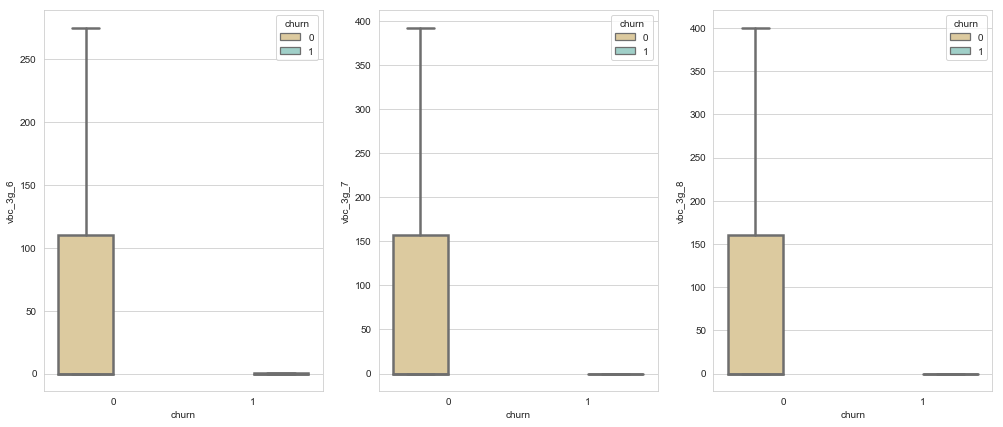

In [59]:
# let's check the volumne based cost for 3G
volumn_based_cost_3g = telecom_data.columns[telecom_data.columns.str.contains('vbc_3g')]

# analyze volume based cost
analyze_feature('vbc_3g')

We can clearly see that volume based cost for 3G is much lower for Churned customers as compared to Non-Churned Customers and also there is a drop in vbc in 8th month.

In [60]:
# Let us define new derived columns
# 3g volume based cost for good phase: vbc_3g_good_ph
telecom_data['vbc_3g_good_ph'] = (telecom_data['vbc_3g_6'] + telecom_data['vbc_3g_7'])/2

# drop the original columns as these are not longer required
telecom_data.drop(['vbc_3g_6','vbc_3g_7'],axis=1,inplace=True)

#### sachet subscription

In [61]:
# let's check sachet subscription for 2G/3G
sachet_2g_or_3g = telecom_data.columns[telecom_data.columns.str.contains('sachet_2g|sachet_3g',regex=True)]

print(telecom_data.loc[:,sachet_2g_or_3g].describe())

pd.DataFrame([telecom_data.loc[telecom_data.churn==0,sachet_2g_or_3g].mean()
              ,telecom_data.loc[telecom_data.churn==1,sachet_2g_or_3g].mean()],index={'Non Churned','Churned'})

        sachet_2g_6   sachet_2g_7   sachet_2g_8   sachet_3g_6   sachet_3g_7  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean       1.066064      1.214026      1.054865      0.209393      0.227492   
std        2.507197      2.736158      2.535940      0.985674      1.089929   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      0.000000      0.000000   
max       42.000000     48.000000     44.000000     29.000000     35.000000   

        sachet_3g_8  
count  30001.000000  
mean       0.202393  
std        1.100107  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       41.000000  


,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
Non Churned,1.069289,1.244368,1.127042,0.206703,0.228247,0.215110
Churned,1.030928,0.883426,0.268438,0.238699,0.219270,0.063838


There is a steep drop in sachet services in 8th month for churned cutsomers as compared to non churned customers

In [62]:
# Let us define two new derived columns
# 2G sachet for good phase: sachet_2g_good_ph
# 3G sachet for good phase: sachet_3g_good_ph
telecom_data['sachet_2g_good_ph'] = (telecom_data.sachet_2g_6 + telecom_data.sachet_2g_7)/2
telecom_data['sachet_3g_good_ph'] = (telecom_data.sachet_3g_6 + telecom_data.sachet_3g_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['sachet_2g_6','sachet_2g_7'
              ,'sachet_3g_6','sachet_3g_7'],axis=1,inplace=True)

#### Age on network

In [63]:
# let's check the age on n/w for churned and non churned customers
print(telecom_data.loc[telecom_data.churn==1,'aon'].mean())
print(telecom_data.loc[telecom_data.churn==0,'aon'].mean())

859.3049167327517
1241.4973252301759


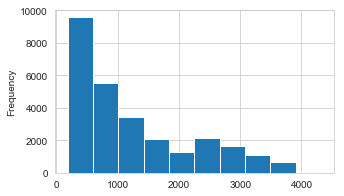

In [64]:
# let's check the age distribution for non churned customers
plt.figure(figsize=(5,3))
telecom_data.loc[telecom_data.churn==0,'aon'].plot.hist()

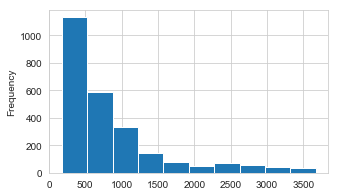

In [65]:
# let's check the age distribution for churned customers
plt.figure(figsize=(5,3))
telecom_data.loc[telecom_data.churn==1,'aon'].plot.hist()

We see from above that most of the churn cases are happening before age 1500 days.

In [66]:
# let's check the circle id values
telecom_data.circle_id.unique()

# let's drop this column as there is only one circle id
telecom_data.drop('circle_id',inplace=True,axis=1)

#### date related variables

In [67]:
# extract the date columns
date_columns = telecom_data.columns[telecom_data.columns.str.contains('date')]

# convert to datetime
for date_col in list(date_columns):
    telecom_data[date_col]= pd.to_datetime(telecom_data[date_col])

In [68]:
print(telecom_data.last_date_of_month_6.dt.day.unique(),telecom_data.last_date_of_month_7.dt.day.unique()
      ,telecom_data.last_date_of_month_8.dt.day.unique())

# as only 1 unique value last day of month is present these columns are not adding much information
# let us drop the columns
telecom_data.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'],axis=1,inplace=True)

[30] [31. nan] [31. nan]


In [69]:
# let's extract the day of last recharge
telecom_data['day_of_last_rech_6'] =  telecom_data.date_of_last_rech_6.dt.day
telecom_data['day_of_last_rech_7'] =  telecom_data.date_of_last_rech_7.dt.day
telecom_data['day_of_last_rech_8'] =  telecom_data.date_of_last_rech_8.dt.day

dt_of_last_rech_cols = ['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8']

pd.DataFrame([telecom_data.loc[telecom_data.churn==0,dt_of_last_rech_cols].median()
              ,telecom_data.loc[telecom_data.churn==1,dt_of_last_rech_cols].median()],index={'Non Churned','Churned'})

,day_of_last_rech_6,day_of_last_rech_7,day_of_last_rech_8
Non Churned,28.0,29.0,29.0
Churned,28.0,27.0,26.0


We can see that the median value for last recharge is bit lower for churned customers

In [70]:
# let's define a new derived column indicating the shift in day of last recharge

telecom_data['day_of_last_rech_shift'] = telecom_data.day_of_last_rech_8 -(telecom_data.day_of_last_rech_6+telecom_data.day_of_last_rech_7)/2

In [71]:
# let's check how the shift indicates pattern for Churned and non churn customers
pd.DataFrame([telecom_data.loc[telecom_data.churn==0,['day_of_last_rech_shift']].median()
              ,telecom_data.loc[telecom_data.churn==1,['day_of_last_rech_shift']].median()],index={'Non Churned','Churned'})

,day_of_last_rech_shift
Non Churned,0.5
Churned,-2.0


We can clearly see that a large negative shift is highly indicative of churn

In [72]:
# let's delete the other colummns derived as are no longer required
telecom_data.drop(['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8'],axis=1,inplace=True)

In [73]:
# let's extract the day of last recharge for data
telecom_data['day_of_last_rech_data_6'] =  telecom_data.date_of_last_rech_data_6.dt.day
telecom_data['day_of_last_rech_data_7'] =  telecom_data.date_of_last_rech_data_7.dt.day
telecom_data['day_of_last_rech_data_8'] =  telecom_data.date_of_last_rech_data_8.dt.day

dt_of_last_rech_cols = ['day_of_last_rech_data_6','day_of_last_rech_data_7','day_of_last_rech_data_8']

pd.DataFrame([telecom_data.loc[telecom_data.churn==0,dt_of_last_rech_cols].median()
              ,telecom_data.loc[telecom_data.churn==1,dt_of_last_rech_cols].median()],index={'Non Churned','Churned'})

,day_of_last_rech_data_6,day_of_last_rech_data_7,day_of_last_rech_data_8
Non Churned,22.0,24.0,23.0
Churned,23.0,20.0,15.0


In [74]:
# let's define a new derived column indicating the shift in day of last data recharge

telecom_data['day_of_last_rech_data_shift'] = telecom_data.day_of_last_rech_data_8 -(telecom_data.day_of_last_rech_data_6+telecom_data.day_of_last_rech_data_7)/2

In [75]:
# let's check how the shift indicates pattern for Churned and non churn customers
pd.DataFrame([telecom_data.loc[telecom_data.churn==0,['day_of_last_rech_data_shift']].median()
              ,telecom_data.loc[telecom_data.churn==1,['day_of_last_rech_data_shift']].median()],index={'Non Churned','Churned'})

,day_of_last_rech_data_shift
Non Churned,-0.5
Churned,-6.0


In [76]:
# let's delete the other colummns derived as are no longer required
telecom_data.drop(['day_of_last_rech_data_6','day_of_last_rech_data_7','day_of_last_rech_data_8'],axis=1,inplace=True)

In [77]:
# let us drop the date columns as we have derived day of month variables from them
telecom_data.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'],axis=1,inplace=True)
telecom_data.drop(['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'],axis=1,inplace=True)

#### average revenue per user

Churn Stats (mean and standard deviation):
{6: 'arpu_6', 7: 'arpu_7', 8: 'arpu_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Non Churned,549.23,562.86,533.26,447.05,474.10,504.14
Churned,659.36,538.11,239.87,579.28,537.32,386.45


<Figure size 1224x504 with 0 Axes>

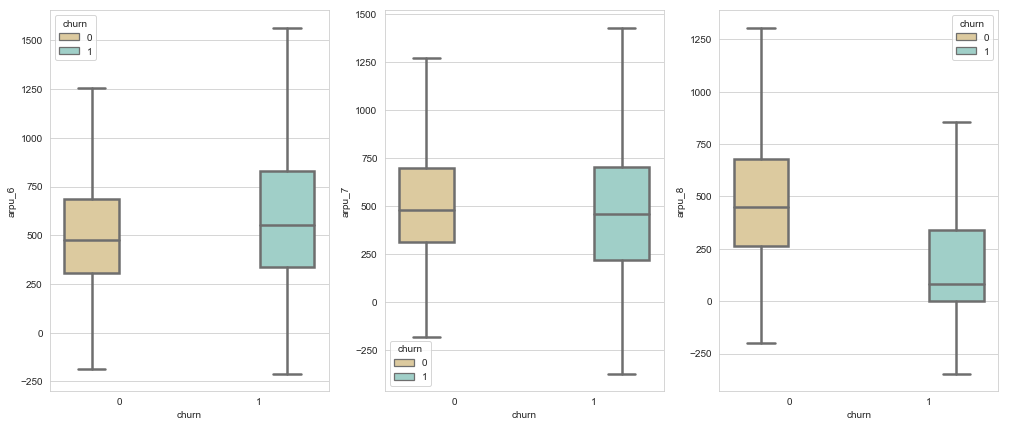

In [78]:
# extract columns for average revenue per user
arpu_cols = telecom_data.columns[telecom_data.columns.str.contains('arpu_')]

# analyze arpu
analyze_feature('arpu')

We can see that arpu also drops signficantly in action phase for churned customers

In [79]:
# Let us define new derived columns
# arpu for good phase: arpu_good_ph
telecom_data['arpu_good_ph'] = (telecom_data.arpu_6 + telecom_data.arpu_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['arpu_6','arpu_7'],axis=1,inplace=True)

#### Minutes of Usage related variables

In [80]:
# let's derive minutes of usage columns
mou_cols = telecom_data.columns[telecom_data.columns.str.contains('mou')]

In [81]:
mou_cols

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7',
       'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_o

In [82]:
# let's check if there are any zero variation columns among these
zero_var_cols = telecom_data.loc[:,mou_cols].std()[telecom_data.loc[:,mou_cols].std()==0].index.values

zero_var_cols

array(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'],
      dtype=object)

In [83]:
# let's drop these columns
telecom_data.drop(list(zero_var_cols),axis=1,inplace=True)

In [84]:
# let's check the % of null values among mou variables
mou_cols = telecom_data.columns[telecom_data.columns.str.contains('mou')]
100*telecom_data.loc[:,mou_cols].isnull().sum()/len(telecom_data.loc[:,mou_cols])

onnet_mou_6         1.816606
onnet_mou_7         1.789940
onnet_mou_8         3.913203
offnet_mou_6        1.816606
offnet_mou_7        1.789940
offnet_mou_8        3.913203
roam_ic_mou_6       1.816606
roam_ic_mou_7       1.789940
roam_ic_mou_8       3.913203
roam_og_mou_6       1.816606
roam_og_mou_7       1.789940
roam_og_mou_8       3.913203
loc_og_t2t_mou_6    1.816606
loc_og_t2t_mou_7    1.789940
loc_og_t2t_mou_8    3.913203
loc_og_t2m_mou_6    1.816606
loc_og_t2m_mou_7    1.789940
loc_og_t2m_mou_8    3.913203
loc_og_t2f_mou_6    1.816606
loc_og_t2f_mou_7    1.789940
loc_og_t2f_mou_8    3.913203
loc_og_t2c_mou_6    1.816606
loc_og_t2c_mou_7    1.789940
loc_og_t2c_mou_8    3.913203
loc_og_mou_6        1.816606
loc_og_mou_7        1.789940
loc_og_mou_8        3.913203
std_og_t2t_mou_6    1.816606
std_og_t2t_mou_7    1.789940
std_og_t2t_mou_8    3.913203
std_og_t2m_mou_6    1.816606
std_og_t2m_mou_7    1.789940
std_og_t2m_mou_8    3.913203
std_og_t2f_mou_6    1.816606
std_og_t2f_mou

In [85]:
# let's check the maximum % of missing value
100*telecom_data.loc[:,mou_cols].isnull().sum().max()/len(telecom_data.loc[:,mou_cols])

3.913202893236892

So for all minutes of usage columns the maximum missing % is 3.19 which seems that in these case the mobile has not been used at all for that particular call type(ic,std etc.), thus it is safe to assume that we can impute the missing values with zero.

In [86]:
# replaceing null values by 0 for minutes of usage variables
telecom_data.loc[:,mou_cols] = telecom_data.loc[:,mou_cols].replace(np.NaN,0)

Lets now now analyze the sub groups of minutes of usage, following groups are there:
* og: outgoing calls
* ic: incoming calls
* offnet: all kinds of calls outside operator network
* onnet: all kinds of call within same operator network

Let us start by analyzing minutes for usage variables for month 6

In [87]:
# let's collect mou variables for month 6
mou_6 = telecom_data.columns[telecom_data.columns.str.contains('mou_6')]

In [88]:
mou_6

Index(['onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6',
       'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6',
       'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6',
       'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6',
       'spl_og_mou_6', 'total_og_mou_6', 'loc_ic_t2t_mou_6',
       'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6',
       'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6',
       'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6'],
      dtype='object')

Let's check the outgoing mou variables.

In [89]:
mou_og_cols6 = telecom_data.columns[telecom_data.columns.str.contains('.*_og_.*mou_6',regex=True)]

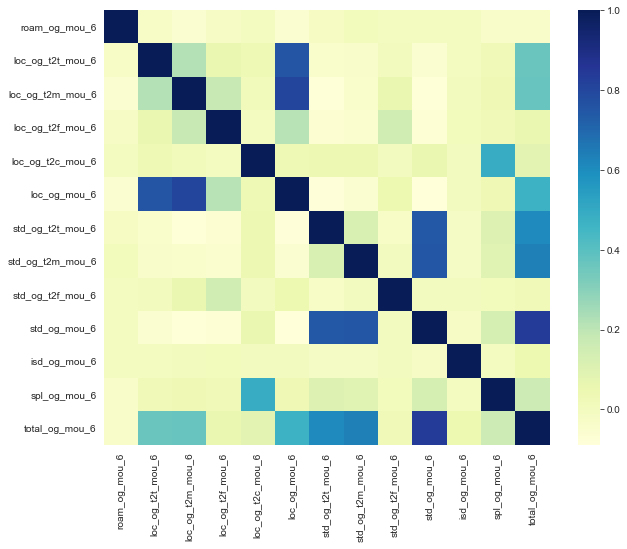

In [90]:
#sns.heatmap(telecom_data.loc[:,mou_cols6].corr())

# let us create a correlation matrix heatmap among quantitative varibales
plt.figure(figsize=(10, 8))
sns.heatmap(telecom_data.loc[:,mou_og_cols6].corr(), cmap="YlGnBu")
plt.show()

After analyzing the variables, we acertain the following rlationships among variables: 

* **total_og_mou_6 = loc_og_mou_6+std_og_mou_6+spl_og_mou_6+isd_og_mou_6+ roam_og_mou_6+og_others_6**
* **std_og_mou_6 = std_og_t2m_mou_6+std_og_t2t_mou_6+std_og_t2f_mou_6 + std_og_2tc_mou_6**
* **loc_og_mou_6 = loc_og_t2m_mou_6+loc_og_t2t_mou_6+loc_og_t2f_mou_6 + loc_og_2tc_mou_6**

In [91]:
## fact checking!!
print(telecom_data.loc[7,'total_og_mou_6'],telecom_data.loc[7,['loc_og_mou_6','std_og_mou_6','spl_og_mou_6','isd_og_mou_6','og_others_6']].sum())

print(telecom_data.loc[7,'std_og_mou_6'],telecom_data.loc[7,['std_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2f_mou_6','std_og_loc_mou_6']].sum())

print(telecom_data.loc[7,'loc_og_mou_6'],telecom_data.loc[7,['loc_og_t2m_mou_6','loc_og_t2t_mou_6','loc_og_t2f_mou_6','loc_og_2tc_mou_6']].sum())

487.53 487.52000000000004
60.86 60.849999999999994
422.16 422.15


In [92]:
# As total_og_mou_6, std_og_mou_6 and loc_og_mou_6 already have component variables present in dataset
# let's remove these columns for all months from the data set

ls_total_og_cols = telecom_data.columns[telecom_data.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]

print(ls_total_og_cols)

telecom_data.drop(ls_total_og_cols,axis=1,inplace=True)

Index(['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6',
       'std_og_mou_7', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7',
       'total_og_mou_8'],
      dtype='object')


In [93]:
# let's define good phase derived variables for all og components:
telecom_data['spl_og_mou_good_ph'] = (telecom_data.spl_og_mou_6 + telecom_data.spl_og_mou_7)/2
telecom_data['isd_og_mou_good_ph'] = (telecom_data.isd_og_mou_6 + telecom_data.isd_og_mou_7)/2
telecom_data['roam_og_mou_good_ph'] = (telecom_data.roam_og_mou_6 + telecom_data.roam_og_mou_7)/2
telecom_data['std_og_t2m_mou_good_ph'] = (telecom_data.std_og_t2m_mou_6 + telecom_data.std_og_t2m_mou_7)/2
telecom_data['std_og_t2t_mou_good_ph'] = (telecom_data.std_og_t2t_mou_6 + telecom_data.std_og_t2t_mou_7)/2
telecom_data['std_og_t2f_mou_good_ph'] = (telecom_data.std_og_t2f_mou_6 + telecom_data.std_og_t2f_mou_7)/2

telecom_data['loc_og_t2m_mou_good_ph'] = (telecom_data.loc_og_t2m_mou_6 + telecom_data.loc_og_t2m_mou_7)/2
telecom_data['loc_og_t2t_mou_good_ph'] = (telecom_data.loc_og_t2t_mou_6 + telecom_data.loc_og_t2t_mou_7)/2
telecom_data['loc_og_t2f_mou_good_ph'] = (telecom_data.loc_og_t2f_mou_6 + telecom_data.loc_og_t2f_mou_7)/2
telecom_data['loc_og_t2c_mou_good_ph'] = (telecom_data.loc_og_t2c_mou_6 + telecom_data.loc_og_t2c_mou_7)/2

In [94]:
# drop all the original og mou variables
ls_og = telecom_data.columns[telecom_data.columns.str.contains('.*_og_.*mou_6|.*_og_.*mou_7',regex=True)]

print(ls_og)

telecom_data.drop(ls_og,axis=1,inplace=True)

Index(['roam_og_mou_6', 'roam_og_mou_7', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'isd_og_mou_6', 'isd_og_mou_7', 'spl_og_mou_6',
       'spl_og_mou_7'],
      dtype='object')


**Let's check for incoming mou variables**

In [95]:
mou_ic_cols6 = telecom_data.columns[telecom_data.columns.str.contains('.*_ic_.*mou_6',regex=True)]

mou_ic_cols6

Index(['roam_ic_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6',
       'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6',
       'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6',
       'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6'],
      dtype='object')

As with og mou variables above, we observe the following relationship among ic (incoming)mou variables:

* **total_ic_mou_6 = loc_ic_mou_6 + std_ic_mou_6 + roam_ic_mou_6 + isd_ic_mou_6 + spl_ic_mou_6 + ic_others_6**
* **loc_ic_mou_6 = loc_ic_t2t_mou_6 + loc_ic_t2m_mou_6+loc_ic_t2f_mou_6+loc_ic_t2c_mou_6**
* **std_ic_mou_6 = std_ic_t2t_mou_6 + std_ic_t2m_mou_6 + std_ic_t2f_mou_6+std_ic_t2c_mou_6**

In [96]:
# fact checking!!
print(telecom_data.loc[7,'total_ic_mou_6'],telecom_data.loc[7,['loc_ic_mou_6','roam_ic_mou_6','isd_ic_mou_6','spl_ic_mou_6','std_ic_mou_6']].sum())

print(telecom_data.loc[7,'loc_ic_mou_6'],telecom_data.loc[7,['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','loc_ic_t2c_mou_6']].sum())

print(telecom_data.loc[7,'std_ic_mou_6'],telecom_data.loc[7,['std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6','std_ic_t2c_mou_6']].sum())

626.46 626.92
427.88 427.86
180.54 180.51999999999998


In [97]:
# As total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 already have component variables present in dataset
# let's remove these columns for all months from the data set

ls_total_ic_cols = telecom_data.columns[telecom_data.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]

print(ls_total_ic_cols)

telecom_data.drop(ls_total_ic_cols,axis=1,inplace=True)

Index(['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6',
       'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7',
       'total_ic_mou_8'],
      dtype='object')


In [98]:
# let's define good phase derive variables for all ic components:
telecom_data['spl_ic_mou_good_ph'] = (telecom_data.spl_ic_mou_6 + telecom_data.spl_ic_mou_7)/2
telecom_data['isd_ic_mou_good_ph'] = (telecom_data.isd_ic_mou_6 + telecom_data.isd_ic_mou_7)/2
telecom_data['roam_ic_mou_good_ph'] = (telecom_data.roam_ic_mou_6 + telecom_data.roam_ic_mou_7)/2
telecom_data['std_ic_t2m_mou_good_ph'] = (telecom_data.std_ic_t2m_mou_6 + telecom_data.std_ic_t2m_mou_7)/2
telecom_data['std_ic_t2t_mou_good_ph'] = (telecom_data.std_ic_t2t_mou_6 + telecom_data.std_ic_t2t_mou_7)/2
telecom_data['std_ic_t2f_mou_good_ph'] = (telecom_data.std_ic_t2f_mou_6 + telecom_data.std_ic_t2f_mou_7)/2

telecom_data['loc_ic_t2m_mou_good_ph'] = (telecom_data.loc_ic_t2m_mou_6 + telecom_data.loc_ic_t2m_mou_7)/2
telecom_data['loc_ic_t2t_mou_good_ph'] = (telecom_data.loc_ic_t2t_mou_6 + telecom_data.loc_ic_t2t_mou_7)/2
telecom_data['loc_ic_t2f_mou_good_ph'] = (telecom_data.loc_ic_t2f_mou_6 + telecom_data.loc_ic_t2f_mou_7)/2

In [99]:
# drop all the original og mou variables
ls_ic = telecom_data.columns[telecom_data.columns.str.contains('.*_ic_.*mou_6|.*_ic_.*mou_7',regex=True)]

print(ls_ic)

telecom_data.drop(ls_ic,axis=1,inplace=True)

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'std_ic_t2t_mou_6',
       'std_ic_t2t_mou_7', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7',
       'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'spl_ic_mou_6', 'spl_ic_mou_7',
       'isd_ic_mou_6', 'isd_ic_mou_7'],
      dtype='object')


**offnet usage**

In [100]:
 offnet_cols = telecom_data.columns[telecom_data.columns.str.contains('offnet',regex=True)]

Churn Stats (mean and standard deviation):
{6: 'offnet_mou_6', 7: 'offnet_mou_7', 8: 'offnet_mou_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Non Churned,364.92,377.79,352.68,463.15,489.51,490.20
Churned,469.29,381.51,143.30,650.11,591.94,325.64


<Figure size 1224x504 with 0 Axes>

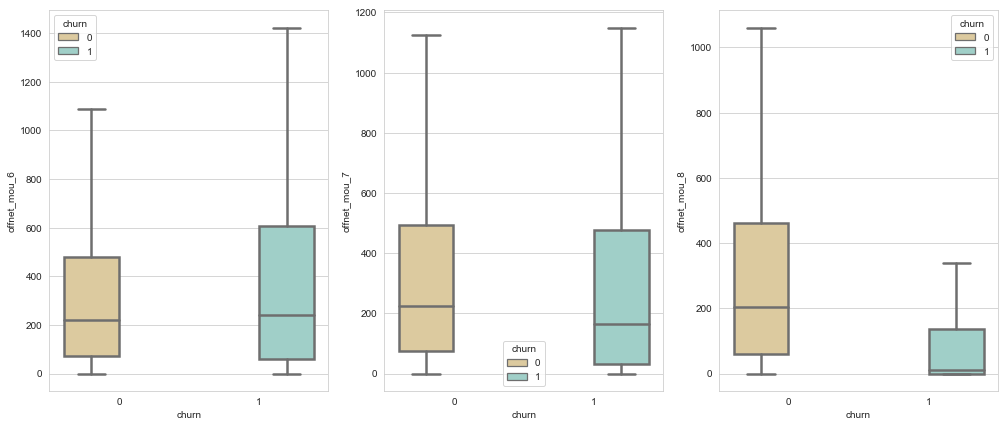

In [101]:
# let's analyze for offnet mou values for churned and non churned customers
analyze_feature('offnet_mou')

there is a substantial decrease in offnet mou for action month.

In [102]:
# Let us define new derived column
# minutes of usage for good phase: onnet_mou_good_ph
telecom_data['offnet_mou_good_ph'] = (telecom_data.offnet_mou_6 + telecom_data.offnet_mou_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['offnet_mou_6','offnet_mou_7'],axis=1,inplace=True)

#### minutes of usage related variables within same operator network

In [103]:
#let's extract the minutes of usage related columns
onnet_cols =  telecom_data.columns[telecom_data.columns.str.contains('^onnet.*mou',regex=True)]

Churn Stats (mean and standard deviation):
{6: 'onnet_mou_6', 7: 'onnet_mou_7', 8: 'onnet_mou_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Non Churned,250.86,265.59,244.98,441.95,474.22,466.25
Churned,369.03,292.15,115.71,610.30,538.45,341.05


<Figure size 1224x504 with 0 Axes>

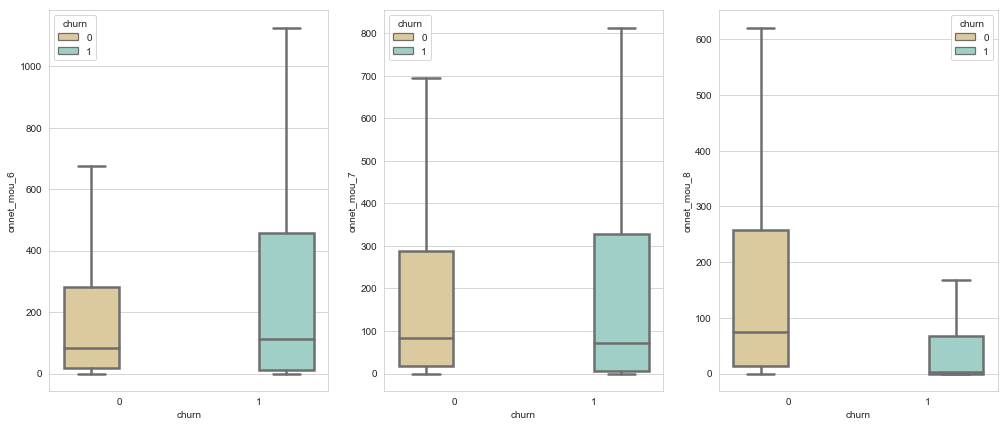

In [104]:
# let's analyze for offnet mou values for churned and non churned customers
analyze_feature('onnet_mou')

We again see that there is a drop in minutes of usage in the action month (8th month) for churned customers

In [105]:
# Let us define new derived column
# minutes of usage for good phase: onnet_mou_good_ph
telecom_data['onnet_mou_good_ph'] = (telecom_data.onnet_mou_6 + telecom_data.onnet_mou_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['onnet_mou_6','onnet_mou_7'],axis=1,inplace=True)

In [106]:
# let's check summary stats for oc others and ic others mou
ls_others = telecom_data.columns[telecom_data.columns.str.contains('_others')]

print(telecom_data.loc[:,ls_others].describe())

        og_others_6   og_others_7   og_others_8   ic_others_6   ic_others_7  \
count  29456.000000  29464.000000  28827.000000  29456.000000  29464.000000   
mean       0.673323      0.043687      0.059953      1.174790      1.527682   
std        4.144797      2.701071      3.381939     14.113843     16.141140   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.060000      0.000000   
max      609.810000    370.130000    394.930000   1344.140000   1495.940000   

        ic_others_8  
count  28827.000000  
mean       1.274322  
std       13.038515  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.060000  
max     1209.860000  


we see from above that very few values are availabe for oc_others and ic_others.

In [107]:
# Let us define two new derived columns
# OG others for good phase: og_others_good_ph
# IC otherd for good phase: ic_others_good_ph
telecom_data['og_others_good_ph'] = (telecom_data.og_others_6 + telecom_data.og_others_7)/2
telecom_data['ic_others_good_ph'] = (telecom_data.ic_others_6 + telecom_data.ic_others_6)/2


# drop the original columns as these are not longer required
telecom_data.drop(['og_others_6','og_others_7','ic_others_6','ic_others_7'],axis=1,inplace=True)

Let's check if there are any more columns with more than 20% NA values remaining.

In [108]:
is_more_than_20 = telecom_data.isnull().sum()/len(telecom_data) > 0.2
100*telecom_data.loc[:,is_more_than_20].isnull().sum()/len(telecom_data.loc[:,is_more_than_20])

night_pck_user_6               44.148528
night_pck_user_7               43.145228
night_pck_user_8               46.825106
fb_user_6                      44.148528
fb_user_7                      43.145228
fb_user_8                      46.825106
day_of_last_rech_data_shift    59.904670
dtype: float64

In [109]:
# lets drop these columns as we have already captured internet volume usage and total data amount recharged.
# also we have captured day of last recharge shift as well.
telecom_data.drop(telecom_data.columns[is_more_than_20],axis=1,inplace=True)

In [110]:
# let's check how many variables are remaining!!
telecom_data.shape

(30001, 78)

In [111]:
is_na = telecom_data.isnull().sum()/len(telecom_data) > 0
100*telecom_data.loc[:,is_na].isnull().sum()/len(telecom_data.loc[:,is_na])

og_others_8               3.913203
ic_others_8               3.913203
day_of_last_rech_shift    2.306590
og_others_good_ph         2.606580
ic_others_good_ph         1.816606
dtype: float64

We can observe that these have very few values a NA indicating that there is no usage in these variables by customer.
Let's impute these values by 0.

In [112]:
telecom_data.loc[:,:] = telecom_data.loc[:,:].replace(np.NaN,0)

### Model building

In this section we will build multiple machine learning models to accurately predict customers who might churn in the action phase (8th Month)

In [113]:
# Putting feature variable to X
X = telecom_data.drop(['churn'],axis=1)

# Putting response variable to 
Y = telecom_data['churn']

Y.head()

0     1
7     1
8     0
21    0
23    0
Name: churn, dtype: int64

### Feature Scaling

We will now train different models on this dataset.

Scaling all values will reduce the distortion due to exceptionally high values and make algorithms converge faster.

In [114]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

We will split the data into a training and a test part. The models will be trained on the training data set and tested on the test data set

In [115]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std,Y, train_size=0.8,test_size=0.2,random_state=111)

In [116]:
print("Training dataset size",X_train.shape)
print("Training dataset target size",y_train.shape)
print("Test dataset size",X_test.shape)
print("Test dataset target size",y_test.shape)

Training dataset size (24000, 77)
Training dataset target size (24000,)
Test dataset size (6001, 77)
Test dataset target size (6001,)


n observations with p features can be interpreted as n points in a p-dimensional space. PCA aims to project this space into a q-dimensional subspace (with q<p) with as little information loss as possible.

It does so by finding the q directions in which the n points vary the most (the principal components). It then projects the original data points into the q-dimensional subspace. PCA returns a n x q dimensional matrix.

Using PCA on our data will decrease the amount of operations during training and testing

In [117]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [118]:
#Doing the PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [119]:
pca.components_

array([[ 3.78430567e-02,  2.83328870e-01,  1.09497651e-01, ...,
         8.67096998e-02,  7.49892764e-04,  1.28881006e-02],
       [ 1.02265425e-04, -6.79338013e-02, -1.81467477e-01, ...,
        -1.93675578e-01, -2.95052899e-02, -3.70598643e-03],
       [-6.41918277e-02,  1.22160213e-01,  1.70201099e-01, ...,
         1.54156482e-01,  2.77928703e-02, -1.85073962e-02],
       ...,
       [ 9.84901247e-04, -2.55402654e-03,  3.33724835e-01, ...,
        -3.73796175e-01,  3.91129115e-05,  2.69059846e-04],
       [-6.12844406e-05, -1.88541963e-03, -4.10171460e-01, ...,
        -2.92122584e-01, -8.31560933e-04,  5.19850560e-04],
       [-3.89154192e-06, -1.65343950e-03, -2.89980854e-01, ...,
         3.97711288e-01,  1.51356798e-04, -1.40883783e-05]])

In [120]:
colnames = list(X.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

,PC1,PC2,Feature
0,0.037843,0.000102,mobile_number
1,0.283329,-0.067934,arpu_8
2,0.109498,-0.181467,onnet_mou_8
3,0.196641,-0.164801,offnet_mou_8
4,0.050364,-0.010433,roam_ic_mou_8


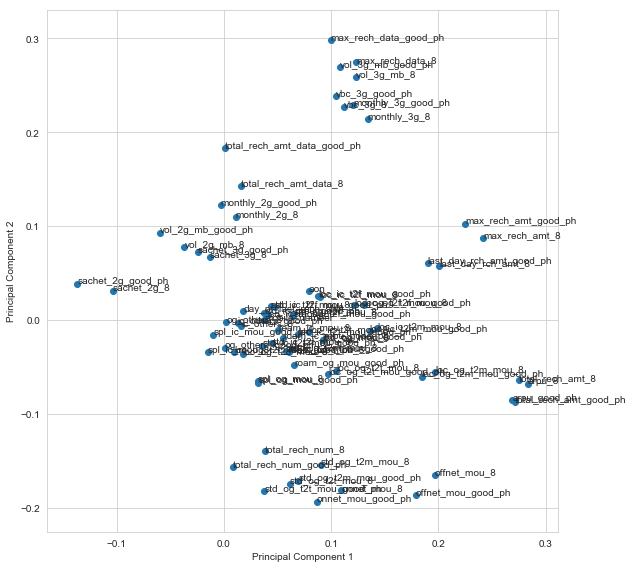

In [121]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [122]:
pca.explained_variance_ratio_

array([9.37214131e-02, 8.76157202e-02, 5.82980515e-02, 4.58818057e-02,
       4.12099192e-02, 3.24572924e-02, 3.15078367e-02, 3.04559596e-02,
       2.99192218e-02, 2.80815309e-02, 2.68923962e-02, 2.51029565e-02,
       2.31408878e-02, 2.21811766e-02, 2.11933282e-02, 1.86874776e-02,
       1.85036357e-02, 1.78220682e-02, 1.67102991e-02, 1.59298534e-02,
       1.55252282e-02, 1.44526072e-02, 1.40321947e-02, 1.36941317e-02,
       1.34492235e-02, 1.30512970e-02, 1.21995464e-02, 1.11353989e-02,
       1.06014601e-02, 1.02607371e-02, 9.94782404e-03, 9.79852372e-03,
       9.44798799e-03, 9.19692673e-03, 8.90017757e-03, 8.59107473e-03,
       8.14968386e-03, 7.73073663e-03, 7.30326756e-03, 6.72758010e-03,
       6.37192979e-03, 6.27854656e-03, 5.82586249e-03, 5.28868249e-03,
       4.87035480e-03, 4.65578876e-03, 4.25885093e-03, 4.06285164e-03,
       3.94083851e-03, 3.81601400e-03, 3.80807790e-03, 3.67051954e-03,
       3.44913984e-03, 3.43365026e-03, 3.38456432e-03, 3.13117005e-03,
      

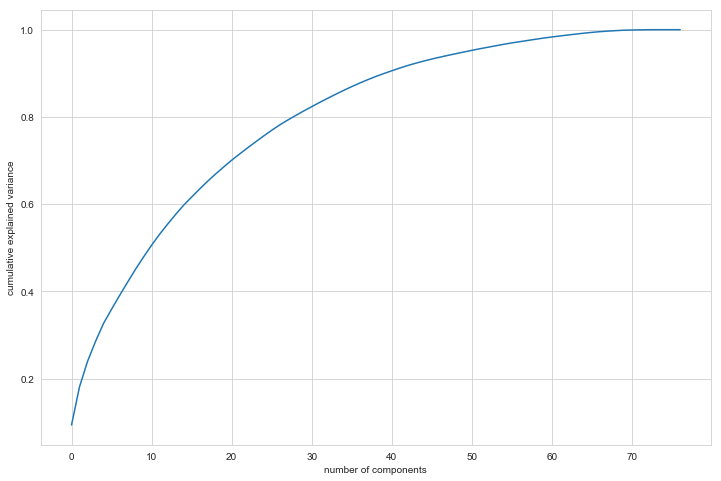

In [123]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [124]:
print("pca.explained_variance_ratio_: ",pca.explained_variance_ratio_.round(3)*100)
print (pca.explained_variance_ratio_.cumsum())
# we see that correlations are indeed very close to 0

pca.explained_variance_ratio_:  [9.4 8.8 5.8 4.6 4.1 3.2 3.2 3.  3.  2.8 2.7 2.5 2.3 2.2 2.1 1.9 1.9 1.8
 1.7 1.6 1.6 1.4 1.4 1.4 1.3 1.3 1.2 1.1 1.1 1.  1.  1.  0.9 0.9 0.9 0.9
 0.8 0.8 0.7 0.7 0.6 0.6 0.6 0.5 0.5 0.5 0.4 0.4 0.4 0.4 0.4 0.4 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.
 0.  0.  0.  0.  0. ]
[0.09372141 0.18133713 0.23963518 0.28551699 0.32672691 0.3591842
 0.39069204 0.421148   0.45106722 0.47914875 0.50604115 0.5311441
 0.55428499 0.57646617 0.5976595  0.61634697 0.63485061 0.65267268
 0.66938298 0.68531283 0.70083806 0.71529067 0.72932286 0.74301699
 0.75646622 0.76951751 0.78171706 0.79285246 0.80345392 0.81371466
 0.82366248 0.833461   0.84290899 0.85210592 0.8610061  0.86959717
 0.87774685 0.88547759 0.89278086 0.89950844 0.90588037 0.91215891
 0.91798478 0.92327346 0.92814381 0.9327996  0.93705845 0.94112131
 0.94506214 0.94887816 0.95268624 0.95635676 0.9598059  0.96323955
 0.96662411 0.96975528 0.97260568 0.97542346 0.9782254

In [125]:
print (pca.explained_variance_ratio_.cumsum())

[0.09372141 0.18133713 0.23963518 0.28551699 0.32672691 0.3591842
 0.39069204 0.421148   0.45106722 0.47914875 0.50604115 0.5311441
 0.55428499 0.57646617 0.5976595  0.61634697 0.63485061 0.65267268
 0.66938298 0.68531283 0.70083806 0.71529067 0.72932286 0.74301699
 0.75646622 0.76951751 0.78171706 0.79285246 0.80345392 0.81371466
 0.82366248 0.833461   0.84290899 0.85210592 0.8610061  0.86959717
 0.87774685 0.88547759 0.89278086 0.89950844 0.90588037 0.91215891
 0.91798478 0.92327346 0.92814381 0.9327996  0.93705845 0.94112131
 0.94506214 0.94887816 0.95268624 0.95635676 0.9598059  0.96323955
 0.96662411 0.96975528 0.97260568 0.97542346 0.97822546 0.98094069
 0.98336223 0.98564785 0.98785262 0.98999683 0.99203547 0.9938662
 0.99551381 0.99678287 0.99786234 0.99882607 0.99925646 0.99964718
 0.99990329 0.99996999 0.99999731 0.9999996  1.        ]


In [126]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=54)

In [127]:
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(24000, 54)

In [128]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

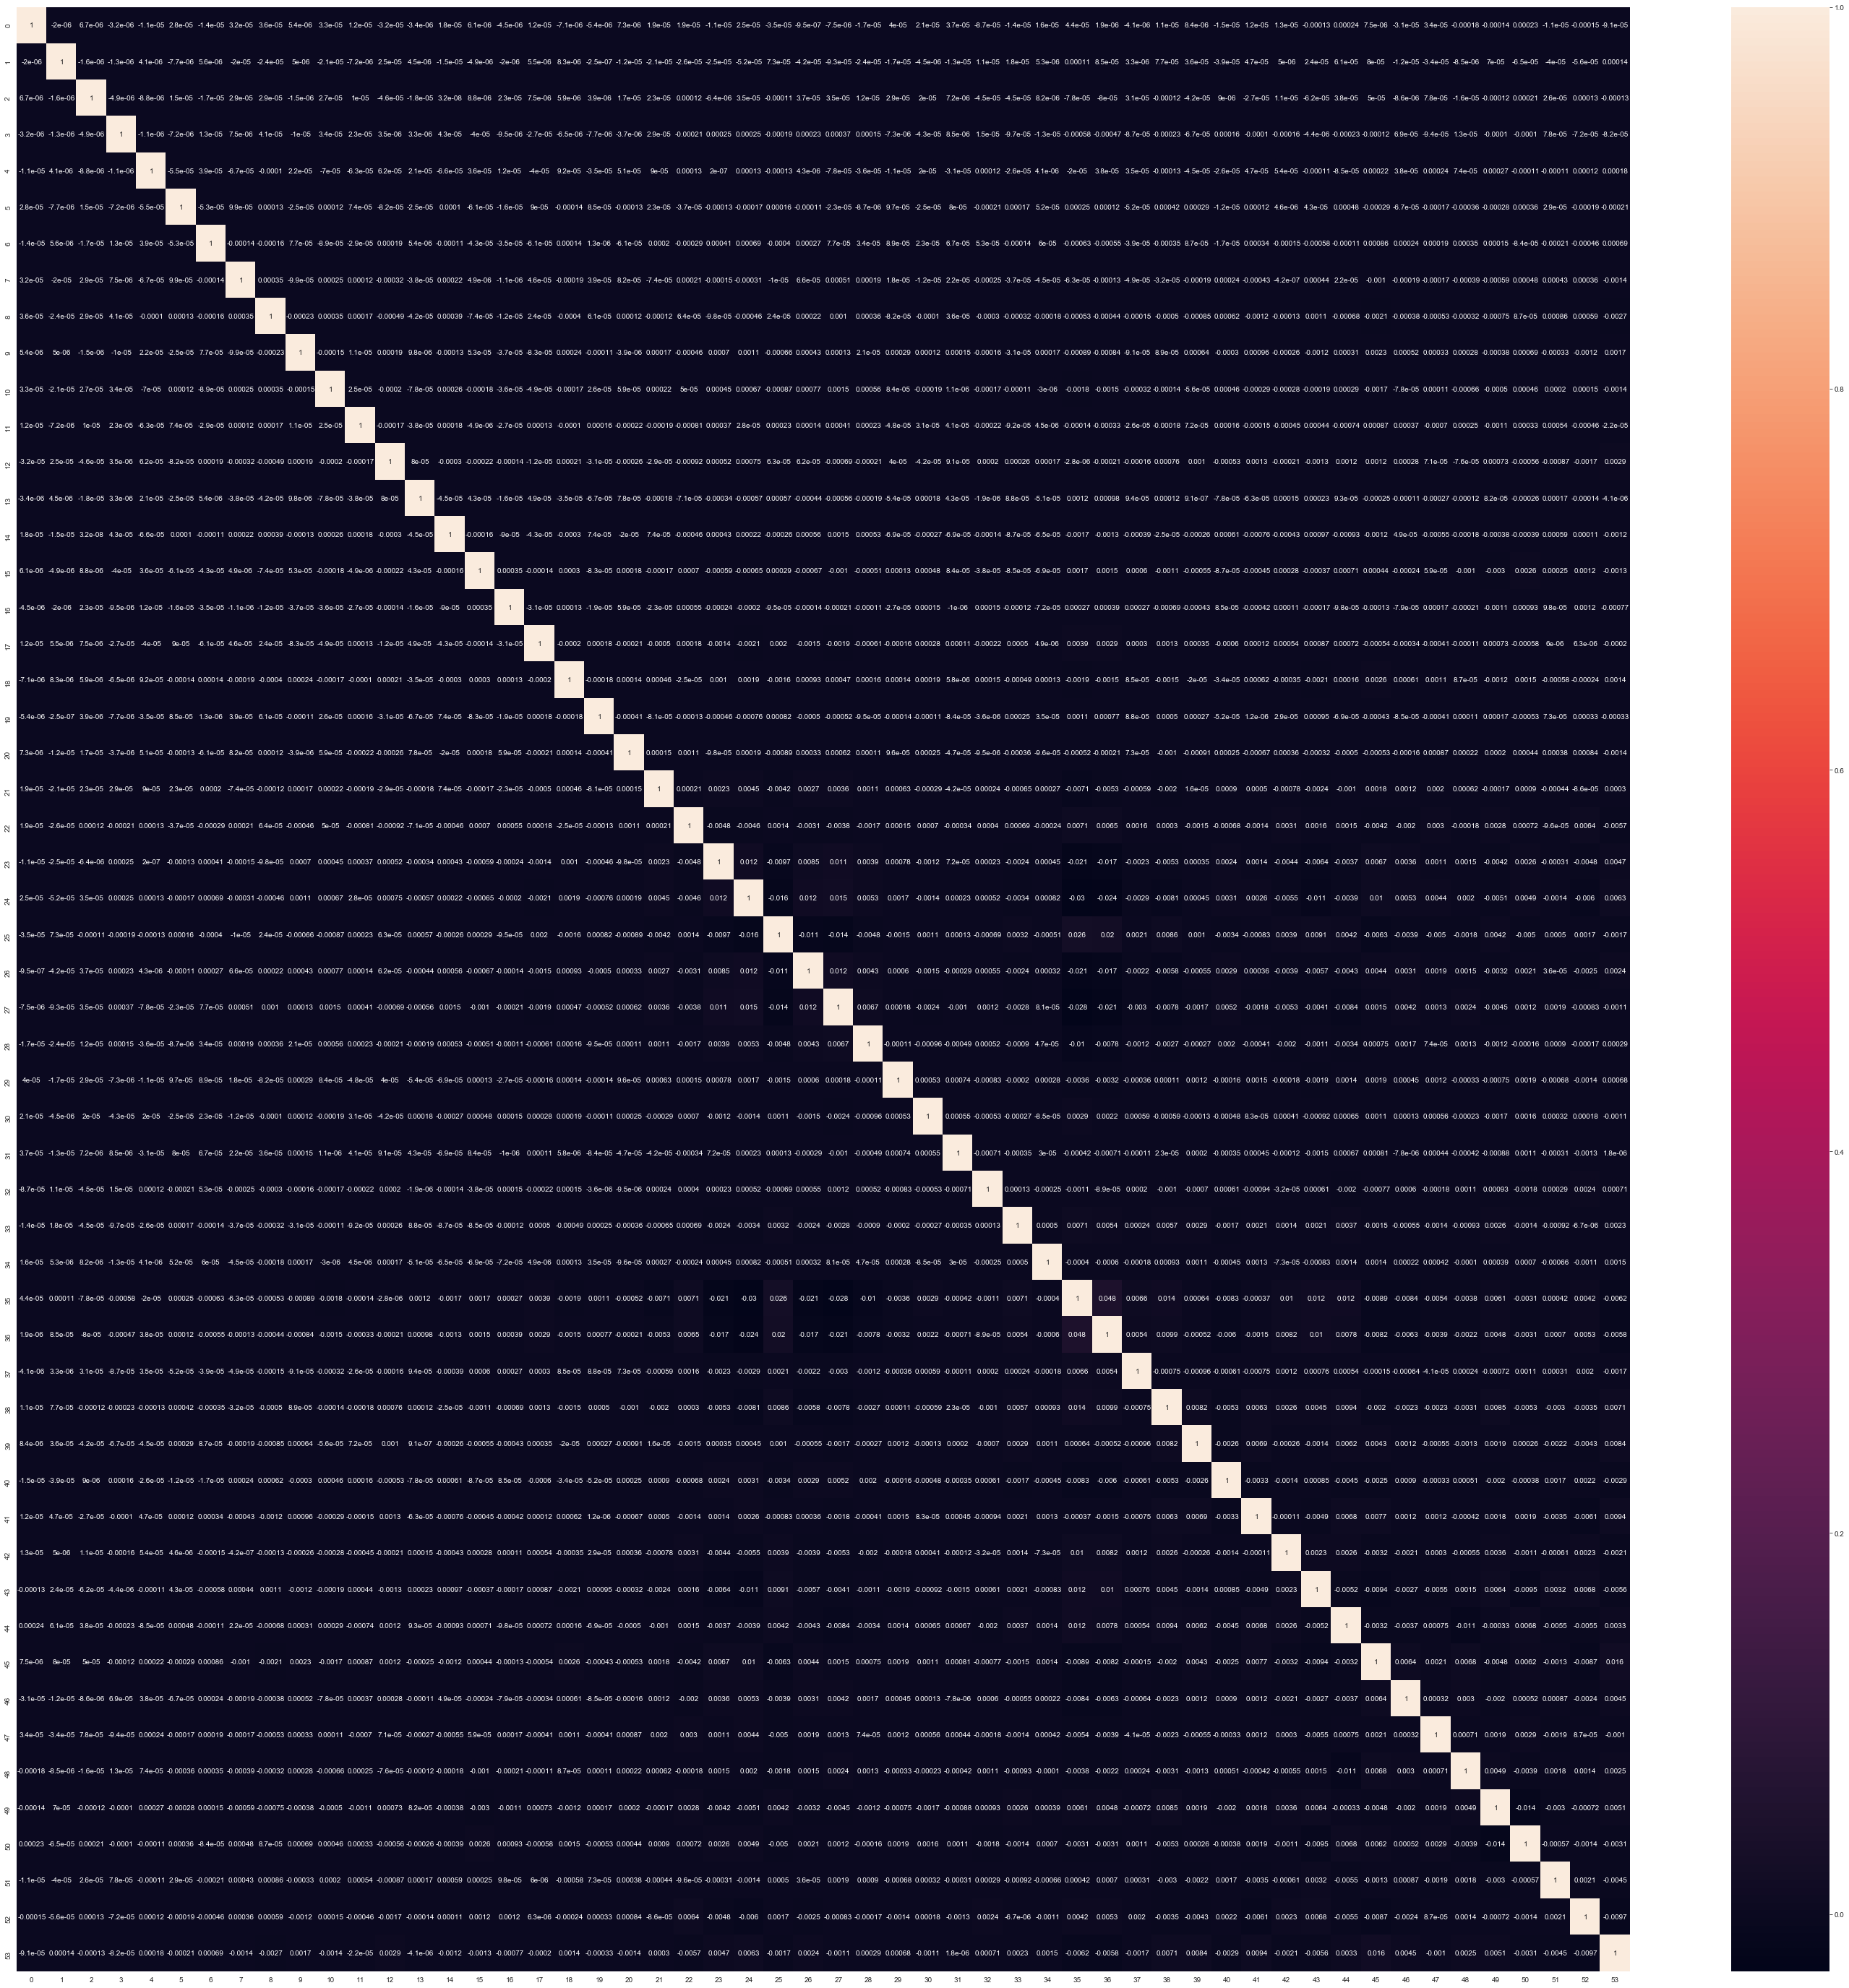

In [129]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (50,50))
sns.heatmap(corrmat,annot = True)

In [130]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.04820010459200199 , min corr:  -0.029886136737104288


In [131]:
#Applying selected components to the test data
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(6001, 54)

### Logistic Regression
<br>
Logistic Regression is a classification algorithm. It is used to predict a binary outcome or Multi class outcome, given a set of independent variables. Logistic regression is a special case of linear regression when the outcome variable is categorical, where we are using log of odds as dependent variable. In simple words, it predicts the probability of occurrence of an event by fitting data to a logit function. <br>

Let's first fit a model with default hyperparameters.

In [132]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression

learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_train)

In [133]:
#Making prediction on the test data
y_pred = model_pca.predict(df_test_pca)
#Making prediction 
y_probs = learner_pca.predict_proba(df_test_pca)[:,1]

In [134]:
printMetrics(y_test,y_pred)

Confusion Matrix: 
 [[5432   83]
 [ 354  132]]
Sensitivity:  0.2716049382716049
Specificity:  0.9849501359927471
AUC Score:  0.6282775371321759
Accuracy:  0.9271788035327445
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5515
           1       0.61      0.27      0.38       486

    accuracy                           0.93      6001
   macro avg       0.78      0.63      0.67      6001
weighted avg       0.91      0.93      0.91      6001



### Lift Metric
<br>
What is Lift measure? <br>

Lift measures expected benefit with the predictive model compared to a base line model – in essence a random choice. It is the ratio of proportion of the gain to the proportion of random expectation at any given decile level. The random expectation at the xth decile is x%.

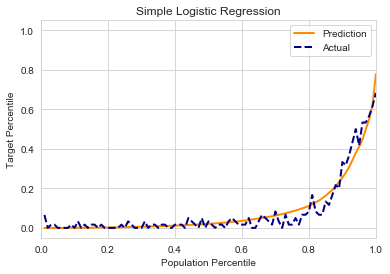

In [135]:
plotLiftChart(y_test.values,y_probs,"Simple Logistic Regression")

### HERE WE CAN SEE SESETIVITY IS VERY LOW .So we have to treat Imbalanced data First

### Imbalanced Data sets
- Machine Learning algorithms tend to produce unsatisfactory classifiers when faced with imbalanced datasets.
    For any imbalanced data set, if the event to be predicted belongs to the minority class and the event rate is less than 5%,
    it is usually referred to as a rare event.
- Standard classifier algorithms like Decision Tree and Logistic Regression have a bias towards classes which have number of instances. They tend to only predict the majority class data. The features of the minority class are treated as noise and are often ignored. Thus, there is a high probability of misclassification of the minority class as compared to the majority class
### Approaches to handle Imbalanced data sets
- Resampling Technique
- Algorithmic Ensemble techinique


### Resampling techniques for Balancing the data set

### Resampling Techniques:
- Random under sampling
    - Balance class distribution by randomly eliminating majority class examples.  This is done until the majority and minority class instances are balanced out.
    
- Random Over sampling
    - Increase the number of instances in the minority class by randomly replicating them in order to present a higher representation of the minority class in the sample.
    
- Cluster based over sampling
    - the K-means clustering algorithm is independently applied to minority and majority class instances. This is to identify clusters in the dataset. Subsequently, each cluster is oversampled such that all clusters of the same class have an equal number of instances and all classes have the same size.
    
- Synthetic Minority Over sampling Technique (SMOTE)
    - This technique is followed to avoid overfitting which occurs when exact replicas of minority instances are added to the main dataset. A subset of data is taken from the minority class as an example and then new synthetic similar instances are created. These synthetic instances are then added to the original dataset. The new dataset is used as a sample to train the classification models.
    
- Modified Synthetic Minority Oversampling Technique (MSMOTE)
    - While the basic flow of MSOMTE is the same as that of SMOTE (discussed in the previous section).  In MSMOTE the strategy of selecting nearest neighbors is different from SMOTE. The algorithm randomly selects a data point from the k nearest neighbors for the security sample, selects the nearest neighbor from the border samples and does nothing for latent noise.

### Algorithmic Ensemble Technique:
- Bagging Based
    - Bagging is an abbreviation of Bootstrap Aggregating. The conventional bagging algorithm involves generating ‘n’ different bootstrap training samples with replacement. And training the algorithm on each bootstrapped algorithm separately and then aggregating the predictions at the end
    - Bagging is used for reducing Overfitting in order to create strong learners for generating accurate predictions. Unlike boosting, bagging allows replacement in the bootstrapped sample.
    
- Boosting Based
     - Boosting is an ensemble technique to combine weak learners to create a strong learner that can make accurate predictions. 
      - Boosting starts out with a base classifier / weak classifier that is prepared on the training data.
- Different Boosting Methods:
      - Ada Boost
      - Gradient Tree Boosting
      - XG Boost

### Random Over Sampling

In [136]:
from imblearn.over_sampling import SMOTE

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(df_train_pca, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Number transactions X_train dataset:  (24000, 77)
Number transactions y_train dataset:  (24000,)
Number transactions X_test dataset:  (6001, 77)
Number transactions y_test dataset:  (6001,)
Before OverSampling, counts of label '1': 2036
Before OverSampling, counts of label '0': 21964 

After OverSampling, the shape of train_X: (43928, 54)
After OverSampling, the shape of train_y: (43928,) 

After OverSampling, counts of label '1': 21964
After OverSampling, counts of label '0': 21964


### Logistic Regression with penalty

In [137]:
from sklearn.model_selection  import StratifiedKFold
stratefied_Kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=9999)

In [138]:
## On resampled dataset

from sklearn.linear_model import LogisticRegressionCV

searchCV = LogisticRegressionCV(
        Cs= list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=stratefied_Kfold
        ,random_state=777
        ,max_iter=100
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=1
        ,verbose = 2
        ,n_jobs = -1
    
    )

searchCV.fit(X_train_res,y_train_res)

#train data
preds_L2Search = searchCV.predict(df_test_pca)
preds_L2Search_probs = searchCV.predict_proba(df_test_pca)[:,1]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   13.8s finished


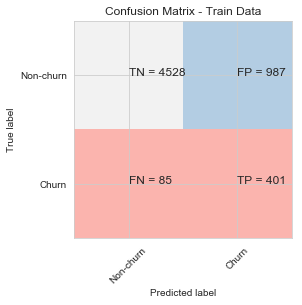

In [139]:
cm = confusion_matrix(y_test, preds_L2Search)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

In [140]:
printMetrics(y_test,preds_L2Search)

Confusion Matrix: 
 [[4528  987]
 [  85  401]]
Sensitivity:  0.8251028806584362
Specificity:  0.8210335448776065
AUC Score:  0.8230682127680212
Accuracy:  0.8213631061489751
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      5515
           1       0.29      0.83      0.43       486

    accuracy                           0.82      6001
   macro avg       0.64      0.82      0.66      6001
weighted avg       0.93      0.82      0.86      6001



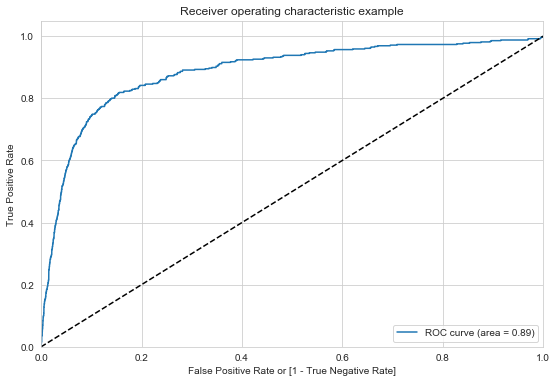

In [141]:
draw_roc(y_test, preds_L2Search_probs)

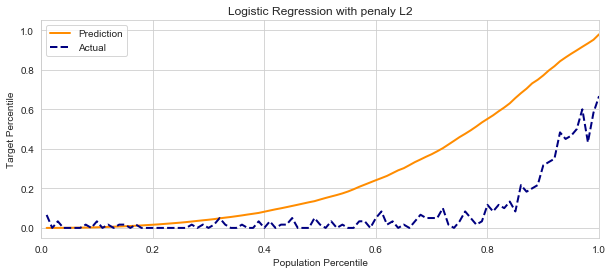

In [142]:
plotLiftChart(y_test.values,preds_L2Search_probs,"Logistic Regression with penaly L2")

### Random Forest

In [143]:
from sklearn.ensemble import RandomForestClassifier
RFC_balanced = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None,
                                      min_samples_split=500, min_samples_leaf=1, 
                                      min_weight_fraction_leaf=0.0, max_features='auto', 
                                      max_leaf_nodes=None, min_impurity_split=1e-07,
                                      bootstrap=True, oob_score=False, n_jobs=-1, 
                                      random_state=9999, verbose=0, warm_start=False, 
                                      class_weight="balanced_subsample")


In [144]:
#On resampled dataset

TrainedRFC= RFC_balanced.fit(X_train_res,y_train_res)

preds_RFC=TrainedRFC.predict(df_test_pca)
preds_probs_RFC=TrainedRFC.predict_proba(df_test_pca)[:,1]


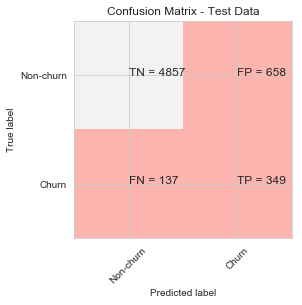

In [145]:
cm = confusion_matrix(y_test, preds_RFC)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

In [146]:
printMetrics(y_test,preds_RFC)

Confusion Matrix: 
 [[4857  658]
 [ 137  349]]
Sensitivity:  0.7181069958847737
Specificity:  0.8806890299184044
AUC Score:  0.7993980129015891
Accuracy:  0.8675220796533911
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      5515
           1       0.35      0.72      0.47       486

    accuracy                           0.87      6001
   macro avg       0.66      0.80      0.70      6001
weighted avg       0.92      0.87      0.89      6001



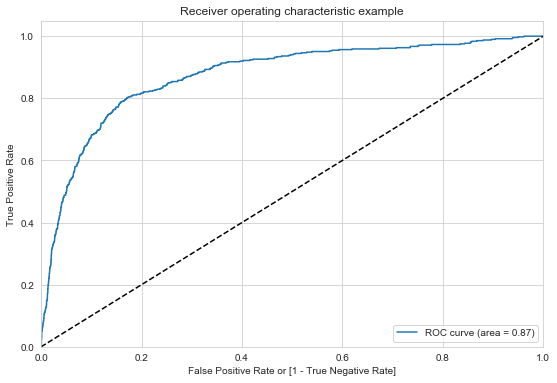

In [147]:
draw_roc(y_test, preds_probs_RFC)

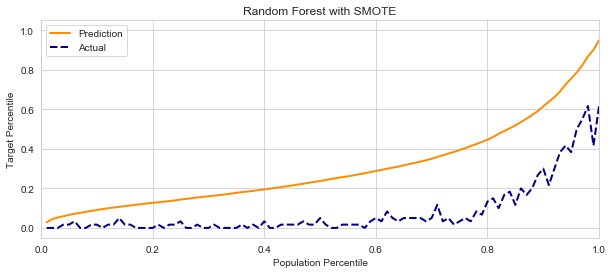

In [148]:
plotLiftChart(y_test.values,preds_probs_RFC,"Random Forest with SMOTE")

### TUNED RANDOM FOREST

In [149]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_res,y_train_res)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  4.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [150]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.410884,0.371323,0.021988,0.003844,entropy,5,50,50,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.832119,0.837469,0.832916,0.833827,0.830260,0.833318,0.002385,12
1,3.577981,0.051992,0.022187,0.002313,entropy,5,50,100,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.830526,0.835761,0.831323,0.831778,0.817509,0.829380,0.006204,16
2,3.315144,0.613596,0.017990,0.001095,entropy,5,100,50,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.827453,0.834168,0.833030,0.824038,0.830032,0.829744,0.003695,15
3,2.724111,0.007516,0.018190,0.001166,entropy,5,100,100,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.826997,0.837583,0.830753,0.826770,0.828552,0.830131,0.003988,14
4,4.855189,0.554452,0.022987,0.001672,entropy,10,50,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.862395,0.876508,0.873094,0.870590,0.866576,0.869832,0.004934,3
5,4.448041,0.018061,0.022187,0.001470,entropy,10,50,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.866151,0.882996,0.870362,0.867630,0.866462,0.870720,0.006315,1
6,4.454438,0.510394,0.024386,0.003977,entropy,10,100,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.850899,0.865695,0.857159,0.857159,0.861111,0.858405,0.004897,6
7,4.982910,0.156558,0.026584,0.003135,entropy,10,100,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.854883,0.861029,0.856476,0.859322,0.855191,0.857380,0.002405,7
8,1.753512,0.194098,0.019190,0.002636,gini,5,50,50,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.828136,0.851810,0.835306,0.827111,0.831626,0.834798,0.008980,9
9,1.577622,0.004407,0.017590,0.000490,gini,5,50,100,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.821762,0.837241,0.840656,0.832461,0.836749,0.833773,0.006546,11


In [151]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.8707202695319614
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [152]:
tunedrfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [153]:

TunedRFC= tunedrfc.fit(X_train_res,y_train_res)

preds_tunedRFC=TunedRFC.predict(df_test_pca)
preds_probs_tunedRFC=TunedRFC.predict_proba(df_test_pca)[:,1]


In [154]:
printMetrics(y_test,preds_tunedRFC)

Confusion Matrix: 
 [[4855  660]
 [ 137  349]]
Sensitivity:  0.7181069958847737
Specificity:  0.8803263825929284
AUC Score:  0.799216689238851
Accuracy:  0.8671888018663556
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      5515
           1       0.35      0.72      0.47       486

    accuracy                           0.87      6001
   macro avg       0.66      0.80      0.70      6001
weighted avg       0.92      0.87      0.89      6001



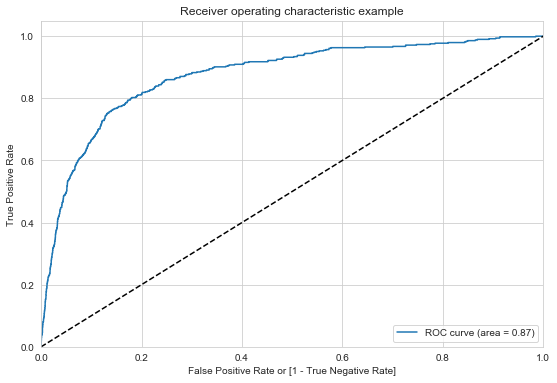

In [155]:
draw_roc(y_test, preds_probs_tunedRFC)

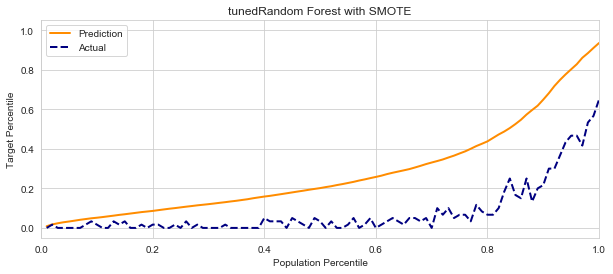

In [156]:
plotLiftChart(y_test.values,preds_probs_tunedRFC,"tunedRandom Forest with SMOTE")

### XG Boost

On resampled data

In [157]:
xgb_model = xgb.XGBClassifier(
    n_estimators=250,
    learning_rate=0.05,
    n_jobs=4,
    max_depth=8,
    colsample_bytree=0.55,
    gamma=0.23,
    cv = None,
    scoring='f1_weighted'
)

xgb_model1 = xgb_model.fit(X_train_res,y_train_res)
preds_tunedxgboost = xgb_model1.predict(df_test_pca)

In [158]:
printMetrics(y_test,preds_tunedxgboost)

Confusion Matrix: 
 [[5133  382]
 [ 174  312]]
Sensitivity:  0.6419753086419753
Specificity:  0.9307343608340889
AUC Score:  0.786354834738032
Accuracy:  0.9073487752041326
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      5515
           1       0.45      0.64      0.53       486

    accuracy                           0.91      6001
   macro avg       0.71      0.79      0.74      6001
weighted avg       0.93      0.91      0.91      6001



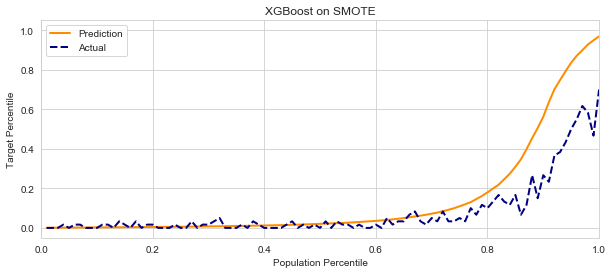

In [159]:
plotLiftChart(y_test.values,xgb_model1.predict_proba(df_test_pca)[:,1],"XGBoost on SMOTE")

## TUNED XGBOOST

In [ ]:
# creating a KFold cross validation 
folds = 3

# specify range of hyperparameters
param_grid = {'scale_pos_weight': [1.8,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89]}

# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'f1', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,n_jobs=3)

In [ ]:
# fit the model
model_cv.fit(X_train_res,y_train_res) 

In [ ]:
# check the best parameters
model_cv.best_params_

In [ ]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.1,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':1,
         'objective':'binary:logistic',
          'scale_pos_weight': 1.87}

# fit model on training data
XGB = XGBClassifier(params = params)
XGB.fit(X_train_res,y_train_res)

In [ ]:
y_pred_xgb =  XGB.predict(df_test_pca)
printMetrics(y_test,y_pred_xgb)

In [ ]:
draw_roc(y_test, y_pred_xgb)

### SVM Linear

On a resampled data

In [ ]:
svm_linear = SVC(kernel='linear',probability=True)
svm_linear.fit(X_train_res, y_train_res)

preds_SVM_li_RS = svm_linear.predict(df_test_pca)
preds_probs_SVM_li_RS=svm_linear.predict_proba(df_test_pca)[:,1]

In [ ]:
printMetrics(y_test,preds_SVM_li_RS)

In [ ]:
draw_roc(y_test, preds_probs_SVM_li_RS)

In [ ]:
plotLiftChart(y_test.values,preds_probs_SVM_li_RS,"Linear SVM on SMOTE")

### SVM Non-linear (RBF)

On resampled data

In [ ]:
svm_rbf = SVC(kernel='rbf',probability=True)
svm_rbf.fit(X_train_res, y_train_res)

preds_SVM_RBF_RS = svm_rbf.predict(df_test_pca)
preds_probs_RBF_RS=svm_rbf.predict_proba(df_test_pca)[:,1]


In [ ]:
printMetrics(y_test,preds_SVM_RBF_RS)

In [ ]:
draw_roc(y_test, preds_probs_RBF_RS)

In [ ]:
plotLiftChart(y_test.values,preds_probs_SVM_li_RS,"RBF SVM on SMOTE")

## Summary about the models



## INTERPRETABLE MODEL : LOGSTIC REGRESSION WITH LASSO

In [ ]:
# Putting feature variable to X
X = telecom_data.drop(['churn','mobile_number'],axis=1)

# Putting response variable to y
y = telecom_data['churn']

In [ ]:
# extract columns
cols = X.columns

# apply standard scalar
scaler = StandardScaler()

# produce scaled features
X_scaled = scaler.fit_transform(X)

# convert to data frame
X_scaled = pd.DataFrame(X_scaled, columns=cols)

In [ ]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, train_size=0.7,test_size=0.3,random_state=100)

from imblearn.over_sampling import SMOTE

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

In [ ]:
X_train_res.head()

In [ ]:
## Lasso Regression Feature Selection
possible_alpha = [i/10 for i in range(1, 100)]
alpha_sensitivity = []

for alpha in possible_alpha:
    lassolr = LogisticRegression(C=alpha, penalty='l1', solver='liblinear')
    lassolr.fit(X_train_res, y_train_res)
    cp = confusion_matrix(y_test, lassolr.predict(X_test))
    alpha_sensitivity.append({"alpha": alpha, "sensitivity": cp[1,1]/(cp[1,0]+cp[1,1])})

pd.DataFrame(alpha_sensitivity).plot.line(x='alpha', y='sensitivity')

In [ ]:
From above we can see that sensitivity is maximized for alpha = 3. 
Let's run model with LASSO (l1) penalty and drop all features with zero coefficients.

In [ ]:
# run with alpha=0.4 and penalty = 'l1'
lassolr = LogisticRegression(C=4, penalty='l1', solver='liblinear')
lassolr.fit(X_train_res, y_train_res)
LR_coefs = dict(zip(X_train_res.columns, lassolr.coef_[0]))
{k:v for k,v in LR_coefs.items() if v == 0}

In [ ]:
We will now create our model, let's create a function to train model and print the model metrics, VIF values with the additional facility to drop columns which are passed in 'cols_to_drop' parameter of the function.

We will run the below function iteratively to reduce features and arrive at final model.

In [ ]:
# function to test model, print metrics, VIF score and can drop columns
def test_model(x_train, x_test, y_train, y_test, cols_to_drop = None):
    cols_to_drop = cols_to_drop or []
    x_train = x_train.drop(cols_to_drop, axis=1)
    x_test = x_test.drop(cols_to_drop, axis=1)
    lr = LogisticRegression(C=4.0, penalty='l1', solver='liblinear')
    lr.fit(x_train, y_train)
    print("Scoring on TEST {}, TRAIN {}".format(lr.score(x_test,y_test), lr.score(x_train,y_train)))
    printMetrics(y_test,lr.predict(x_test))
    x_train = sm.add_constant(x_train)
    stat_model = sm.Logit(y_train, x_train).fit_regularized(method='l1')
    print(stat_model.summary())
    # calculate VIF
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    for i, var in enumerate(x_train.columns):
        ## Even if we are doing a logistic regression above
        ## Do a Linear Regression here as we are just trying 
        ## to fing the variance of the features, how multicollinear
        rsq = sm.OLS(x_train[var], x_train.drop([var], axis=1)).fit().rsquared
        vif = round( 1 / (1 - rsq + 0.00000000001), 2)
        vif_df.loc[i] = [var, vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

In [ ]:
# run model on majority undersampled training data
test_model(X_train_res, X_test, y_train_res, y_test)

In [ ]:
#### Dropping variables with high p-value and high VIF
We run the test_model function iteratively to arrive at the below list of features with high p-value and high VIF to be dropped:

In [ ]:
cols_to_drop=["onnet_mou_8", "std_og_t2m_mou_8", "onnet_mou_good_ph",
       "offnet_mou_good_ph", "roam_ic_mou_good_ph", "loc_og_t2m_mou_good_ph",
      "og_others_8", "total_rech_amt_good_ph", "total_rech_amt_8", "isd_ic_mou_good_ph",
      "arpu_8", "vol_3g_mb_8", "loc_og_t2f_mou_good_ph", "isd_og_mou_8",
      "loc_ic_t2f_mou_good_ph", "spl_og_mou_good_ph", "std_ic_t2m_mou_good_ph",
      "std_og_t2f_mou_good_ph", "total_rech_amt_data_good_ph", "max_rech_data_good_ph",
      "std_ic_t2f_mou_good_ph", "loc_og_t2f_mou_8", "vbc_3g_good_ph", "isd_og_mou_good_ph",
      "total_rech_amt_data_8", "max_rech_amt_good_ph", "total_rech_num_good_ph",
      "sachet_2g_good_ph", "ic_others_8", "std_ic_t2f_mou_8", "og_others_good_ph",
      "ic_others_good_ph", "roam_ic_mou_8", "monthly_3g_good_ph", "loc_ic_t2m_mou_8",
      "loc_ic_t2m_mou_good_ph", "isd_ic_mou_8", "loc_og_t2c_mou_good_ph", "last_day_rch_amt_good_ph",
      "std_og_t2f_mou_8", "sachet_3g_good_ph", "sachet_3g_8", "std_og_t2t_mou_good_ph",
      "spl_ic_mou_good_ph", "loc_og_t2c_mou_8", "spl_og_mou_8", "vbc_3g_8",
      "vol_3g_mb_good_ph", "roam_og_mou_good_ph", "monthly_2g_8", "monthly_3g_8",
      "loc_og_t2t_mou_good_ph", "loc_og_t2t_mou_8", "max_rech_amt_8", "spl_ic_mou_8",
      "std_ic_t2t_mou_good_ph", "std_ic_t2m_mou_8", "std_ic_t2t_mou_8","std_og_t2m_mou_good_ph"]


LR_FEATURES = list(set(X_train_res.columns) - set(cols_to_drop))

In [ ]:
# run with columns to be dropped to check the final p-values and VIF
test_model(X_mju, X_test, y_mju, y_test, cols_to_drop=cols_to_drop)

According to the model below parameters have relative impact on the customer churn
- good phase
- action phase 

@good phase indicator are high then action parameters are dropping hence high possibility of churn.

**Few good phase indicators which when increase lower the possibility of churn are:**

* aon: [age on network]: Customer Churn decreases as the age on network increases.

* arpu_good_ph:[average revenue per user] : Less Defaults if the the average revenue for customer is high in good phase.

* loc_ic_t2t_mou_good_ph: [incoming local calls within operator network]: if the minutes of usage for such calls is high in good phase then lower is the possibility of default.

* vol_2g_mb_good_ph: [volume of 2G data usage]: Less possibility of default if volumne of 2G data usage is high in good phase.

**Few action phase indicators for customer churn are as follows:**

* loc_og_t2m_mou_8: [local outgoing calls from telecom operator to other network mobile]: Indicator of high possibility of customer churn.

* vol_2g_mb_8/sachet_2g_8: [volumne of 2G usage and sachet(small) topup for 2G data]: Indicator of Churn ,if a drop in 2G usage volume of sachet top-ups.

* max_rech_data_8: [maximum data recharge]: Indicatory of default , if the maximum data recharge done by customer drops in action phase .


* loc_ic_t2t_mou_8: [local incoming calls within same telecom network]: Indicator of Defaults, if the local incoming calls for t2t drop in action phase.


* loc_ic_t2f_mou_8: [local incoming calls from fixed line]: Indicator of high Churn ,if a drop in calls from fixed line to customer.

* day_of_last_rech_shift: [shift in day of last recharge as compared to previous month]: Indicator of high Churn ,if the last recharge is not in the last week of month.

* roam_og_mou_8: [roaming outgoing calls]: Indicator of Churn ,increase in outgoing roaming calls can cause customer churn from the operator, as high roaming charges are incurred.

- The percentage of churn is higher is 2G usage as compared to 3G as users migrated to other network due to better 3G network.

### Recommendations

Our Recommendation based on the modelling and the good and action parameters we have identifies is as follows

* Better 2G area coverage where 3G is not available.
* Strong 3G network across 
* Reduce the tarrifs on Roming ,thats the main reason of people moving to local network opertory.
* Based on the behaviour or action parameters , give offers to the customer to stay